Rayleigh-Taylor instability
======

This notebook models the Rayleigh-Taylor instability outlined in Kaus *et al.* (2010). 

**Keywords:** Stress state, Free surface

**References**
1. Kaus, B. J., Mühlhaus, H., & May, D. A. (2010). A stabilization algorithm for geodynamic numerical simulations with a free surface. Physics of the Earth and Planetary Interiors, 181(1-2), 12-20.

![](./images/kaus2010RTI.gif)

In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

import underworld as uw
import underworld.function as fn
import math
import numpy as np

loaded rc file /opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

KL = 500 * u.kilometer
K_viscosity = 1e20  * u.pascal * u.second
K_density   = 3200 * u.kilogram / u.meter**3

KM = K_density * KL**3
Kt = KM/ ( KL * K_viscosity )

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [3]:
nx0 = 50
ny0 = 50

In [4]:
Model = GEO.Model(elementRes=(nx0,ny0),
                  minCoord=(-250. * u.kilometer, -500. * u.kilometer),  
                  maxCoord=(250. * u.kilometer, 0. * u.kilometer),
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

dt = 2.5*u.kiloyear
dt_str = "%.1f" %(dt.m)
checkpoint_interval = 1e2*u.kiloyear
fdir = "1_23_02_FreeSurface_Kaus2010_Rayleigh-Taylor_Instability_dt"+dt_str+"ka_NUM"
Model.outputDir = fdir

	Global element size: 50x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x50
In func WeightsCalculator_CalculateAll(): for swarm "CP5UHT5C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "CP5UHT5C__swarm"


In [5]:
meshz0 = GEO.nd(0.*u.kilometer)
meshz1 = GEO.nd(-250*u.kilometer)
meshz2 = GEO.nd(-500*u.kilometer)

dy1 =  GEO.nd(6.25*u.kilometer)
dy2 = GEO.nd(25.*u.kilometer)

ny1 = int(np.round((meshz1-meshz2)/dy2))
ny2 = int(ny0-ny1) 

In [6]:
Model.fsmeshny = ny2
Model.fsmeshnx = nx0
Model.fsmeshny1 = ny1

minCoord1 = (-250. * u.kilometer, -250. * u.kilometer)
maxCoord1 = (250. * u.kilometer, 0. * u.kilometer) 

Model.fsminCoord = tuple([GEO.nd(val) for val in minCoord1])
Model.fsmaxCoord = tuple([GEO.nd(val) for val in maxCoord1])

In [7]:
Model.mesh.reset()

#meshny1 = 

with Model.mesh.deform_mesh():
    for i in range(0,ny1+1):
            Model.mesh.data[((nx0+1)*i):((nx0+1)*(i+1)),1]= meshz2+dy2*i
    for i in range(ny1+1,ny0):
            Model.mesh.data[((nx0+1)*i):((nx0+1)*(i+1)),1]= meshz1+dy1*(i-ny1)


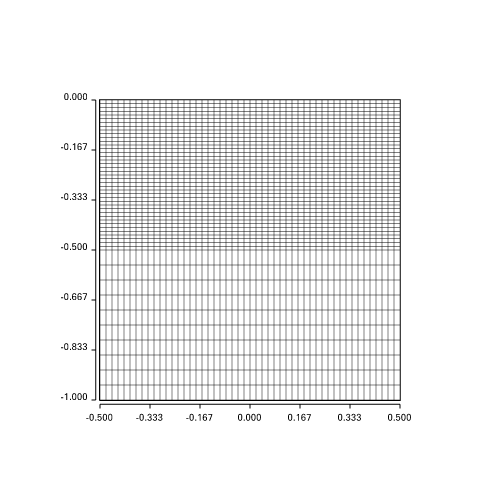

In [8]:
Fig = vis.Figure(figsize=(500, 500),rulers=True,margin = 100,rulerticks=7,quality=3,clipmap=False)
Fig.Mesh(Model.mesh, pointSize=4.0)
#Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)
Fig.show()
#Fig.save("mesh0.jpg")

In [9]:
# IndexSets for compensation depth
axis_cd = np.where((Model.mesh.data[:,1]<=meshz1+dy1/4)&(Model.mesh.data[:,1]>=meshz1-dy1/4))
Sets_cd = Model.mesh.specialSets["Empty"]
for index in axis_cd:
    Sets_cd.add(index)
    
meshz_check = GEO.nd(-150*u.kilometer)
axis_check = np.where((Model.mesh.data[:,1]<=meshz_check+dy1/4)&(Model.mesh.data[:,1]>=meshz_check-dy1/4))
Sets_check = Model.mesh.specialSets["Empty"]
for index in axis_check:
    Sets_check.add(index)   

In [10]:
from underworld.swarm import Swarm
from collections import OrderedDict

Model.swarm_variables = OrderedDict()

Model.swarm = Swarm(mesh=Model.mesh, particleEscape=True)
Model.swarm.allow_parallel_nn = True
if Model.mesh.dim == 2:
    particlesPerCell = GEO.rcParams["swarm.particles.per.cell.2D"]
else:
    particlesPerCell = GEO.rcParams["swarm.particles.per.cell.3D"] 

Model._swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(
    swarm=Model.swarm,
    particlesPerCell=particlesPerCell)

Model.swarm.populate_using_layout(layout=Model._swarmLayout)

Model._initialize()

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"


In [11]:
wavelength = GEO.nd(KL)
amplitude  = GEO.nd(5*u.kilometer)
offset     = GEO.nd(-100.*u.kilometer)
k = 2. * math.pi / wavelength

coord = fn.coord()
perturbationFn = offset + amplitude*fn.math.cos(k*coord[0])

lightShape = perturbationFn > coord[1] 
densShape  = perturbationFn <= coord[1]

densMaterial = Model.add_material(name="Dense Material", shape=densShape)
lightMaterial = Model.add_material(name="Light Material", shape=lightShape)

In [12]:
densMaterial.density  = 3300 * u.kilogram / u.metre**3
lightMaterial.density = 3200 * u.kilogram / u.metre**3

densMaterial.viscosity = 1e21 * u.pascal * u.second
lightMaterial.viscosity = 1e20 * u.pascal * u.second

In [13]:
npoints = 1000
coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = offset + amplitude*np.cos(k*coords[:, 0])

Model.add_passive_tracers(name="interface", vertices=coords)


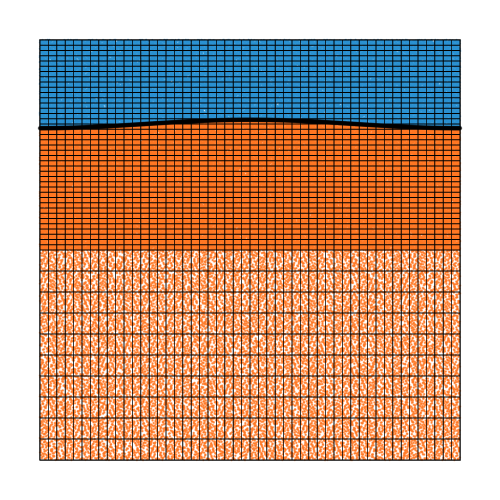

In [14]:
Fig = vis.Figure(figsize=(500, 500))
Fig.Points(Model.interface_tracers, pointSize=5.0)
Fig.Points(Model.swarm, Model.materialField,pointSize=3.,colourBar=False)
Fig.Mesh(Model.mesh)
Fig.save("Fig_Kaus2010RTI_0.png")
Fig.show()

In [16]:
idcell=Model.swarm.owningCell.data
np.where(idcell==0)[0].shape,np.where(idcell==2499)[0].shape,np.where(idcell==2399)[0].shape

((40,), (40,), (40,))

In [18]:
Model.set_velocityBCs(left=[0., None], right=[0., None], top=[None, None], bottom=[0.,0.])

In [19]:
Model.init_model(pressure="lithostatic")

/opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/_model.py:1582: UserWarning: Skipping the steady state calculation: No diffusivity variable defined on Model
  warnings.warn("Skipping the steady state calculation: No diffusivity variable defined on Model")


In [20]:
from _freesurface_NUMesh import FreeSurfaceProcessor
Model.freeSurface = True
Model._freeSurface = FreeSurfaceProcessor(Model)

	Global element size: 50x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x50
	Global element size: 50x40
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x40


In [21]:
Model.run_for(5.5 * u.megayears, checkpoint_interval=checkpoint_interval,dt= dt)

Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.21794e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001303 secs 
  RHS V Solve:            = 0.00397 secs / 8 its
  Pressure Solve:         = 0.02711 secs / 7 its
  Final V Solve:          = 0.003691 secs / 8 its

  Total BSSCR Linear solve time: 0.043932 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 4.461782e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0971 [min] /    0.0971 [max] (secs)
Time Integration - 0.0

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24942e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001333 secs 
  RHS V Solve:            = 0.004254 secs / 8 its
  Pressure Solve:         = 0.03236 secs / 8 its
  Final V Solve:          = 0.003985 secs / 8 its

  Total BSSCR Linear solve time: 0.049675 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 4.997432e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1327 [min] /    0.1327 [max] (secs)
Time Integration - 0.132753 [min] / 0.132753 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.629737e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000905727 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1220 [min] /    0.1220 [max] (secs)
Time Integration - 0.122062 [min] / 0.122062 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 4.458696e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0016 [min] /    0.0016 [max] (secs)
Time Integration - 0.00169481 [min] / 0.00169481 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:    13 Model Time: 32500.0 year dt: 2500.0 year (2022-11-03 04:57:21)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31414e-03 
  Setting schur_pc to "uw" 


Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31080e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001404 secs 
  RHS V Solve:            = 0.004221 secs / 8 its
  Pressure Solve:         = 0.0354 secs / 8 its
  Final V Solve:          = 0.007491 secs / 8 its

  Total BSSCR Linear solve time: 0.056619 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.700600e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0795 [min] /    0.0795 [max] (secs)
Time Integration - 0.0795087 [min] / 0.0795087 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.418974e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000853934

	2nd order:                 D54EKLPT__integrand -    0.0804 [min] /    0.0804 [max] (secs)
Time Integration - 0.0804035 [min] / 0.0804035 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.387236e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000866328 [min] / 0.000866328 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:    26 Model Time: 65000.0 year dt: 2500.0 year (2022-11-03 04:57:30)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31717e-03 
  Setting schur_pc to "uw" 


SCR Solver 

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:    32 Model Time: 80000.0 year dt: 2500.0 year (2022-11-03 04:57:34)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36962e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001459 secs 
  RHS V Solve:            = 0.004288 secs / 8 its
  Pressure Solve:         = 0.03285 secs / 8 its
  Final V Solve:          = 0.003855 secs / 8 its

  Total BSSCR Linear solve time: 0.050564 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.088716e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0789 [min] /    0.0789 [max] (secs)
Tim

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26495e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001353 secs 
  RHS V Solve:            = 0.004062 secs / 8 its
  Pressure Solve:         = 0.0305 secs / 7 its
  Final V Solve:          = 0.004326 secs / 8 its

  Total BSSCR Linear solve time: 0.048193 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 4.849097e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0835 [min] /    0.0835 [max] (secs)
Time Integration - 0.0835674 [min] / 0.0835674 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.450201e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000821595

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32279e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00141 secs 
  RHS V Solve:            = 0.004334 secs / 8 its
  Pressure Solve:         = 0.03321 secs / 8 its
  Final V Solve:          = 0.004035 secs / 8 its

  Total BSSCR Linear solve time: 0.051148 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.145064e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0807 [min] /    0.0807 [max] (secs)
Time Integration - 0.080723 [min] / 0.080723 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.456619e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000808334 [

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0843 [min] /    0.0843 [max] (secs)
Time Integration - 0.0843443 [min] / 0.0843443 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.360933e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000919251 [min] / 0.000919251 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:    51 Model Time: 127500.0 year dt: 2500.0 year (2022-11-03 04:57:48)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29945e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.65782e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00175 secs 
  RHS V Solve:            = 0.004705 secs / 8 its
  Pressure Solve:         = 0.06218 secs / 8 its
  Final V Solve:          = 0.004243 secs / 8 its

  Total BSSCR Linear solve time: 0.084364 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.473161e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0810 [min] /    0.0810 [max] (secs)
Time Integration - 0.081021 [min] / 0.081021 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.402364e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000821729 [

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0798 [min] /    0.0798 [max] (secs)
Time Integration - 0.0798194 [min] / 0.0798194 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.361344e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000855839 [min] / 0.000855839 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:    64 Model Time: 160000.0 year dt: 2500.0 year (2022-11-03 04:57:56)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29385e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29407e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001388 secs 
  RHS V Solve:            = 0.004413 secs / 8 its
  Pressure Solve:         = 0.04153 secs / 10 its
  Final V Solve:          = 0.003728 secs / 7 its

  Total BSSCR Linear solve time: 0.058849 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.918033e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0828 [min] /    0.0828 [max] (secs)
Time Integration - 0.082834 [min] / 0.082834 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.417405e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000869187

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0835 [min] /    0.0835 [max] (secs)
Time Integration - 0.083547 [min] / 0.083547 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.452914e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00092307 [min] / 0.00092307 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:    77 Model Time: 192500.0 year dt: 2500.0 year (2022-11-03 04:58:04)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34994e-03 
  Setting schur_pc to "uw" 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0911 [min] /    0.0911 [max] (secs)
Time Integration - 0.0911706 [min] / 0.0911706 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.374961e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000877695 [min] / 0.000877695 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:    83 Model Time: 207500.0 year dt: 2500.0 year (2022-11-03 04:58:09)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29892e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32072e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001411 secs 
  RHS V Solve:            = 0.004334 secs / 8 its
  Pressure Solve:         = 0.03856 secs / 9 its
  Final V Solve:          = 0.003602 secs / 7 its

  Total BSSCR Linear solve time: 0.055996 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.630286e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0864 [min] /    0.0864 [max] (secs)
Time Integration - 0.08642 [min] / 0.08642 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.417435e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00089536 [mi

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0881 [min] /    0.0881 [max] (secs)
Time Integration - 0.0881455 [min] / 0.0881455 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.428107e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000859172 [min] / 0.000859172 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:    96 Model Time: 240000.0 year dt: 2500.0 year (2022-11-03 04:58:17)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27811e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27042e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001358 secs 
  RHS V Solve:            = 0.004155 secs / 8 its
  Pressure Solve:         = 0.03632 secs / 9 its
  Final V Solve:          = 0.00397 secs / 8 its

  Total BSSCR Linear solve time: 0.053708 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.410557e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0807 [min] /    0.0807 [max] (secs)
Time Integration - 0.080774 [min] / 0.080774 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.323150e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000810407 [

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0836 [min] /    0.0836 [max] (secs)
Time Integration - 0.0836218 [min] / 0.0836218 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.370145e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000837745 [min] / 0.000837745 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   109 Model Time: 272500.0 year dt: 2500.0 year (2022-11-03 04:58:24)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25479e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.41789e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001538 secs 
  RHS V Solve:            = 0.004362 secs / 8 its
  Pressure Solve:         = 0.04176 secs / 10 its
  Final V Solve:          = 0.003722 secs / 7 its

  Total BSSCR Linear solve time: 0.061646 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.198860e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0843 [min] /    0.0843 [max] (secs)
Time Integration - 0.0843119 [min] / 0.0843119 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 2.036614e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008772

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36688e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001462 secs 
  RHS V Solve:            = 0.004306 secs / 8 its
  Pressure Solve:         = 0.03743 secs / 9 its
  Final V Solve:          = 0.004058 secs / 8 its

  Total BSSCR Linear solve time: 0.055434 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.575594e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0869 [min] /    0.0869 [max] (secs)
Time Integration - 0.0869554 [min] / 0.0869554 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.343701e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00087039

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0840 [min] /    0.0840 [max] (secs)
Time Integration - 0.0840673 [min] / 0.0840673 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.102980e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000836488 [min] / 0.000836488 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   128 Model Time: 320000.0 year dt: 2500.0 year (2022-11-03 04:58:37)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24867e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33421e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001427 secs 
  RHS V Solve:            = 0.004245 secs / 8 its
  Pressure Solve:         = 0.03579 secs / 9 its
  Final V Solve:          = 0.003988 secs / 8 its

  Total BSSCR Linear solve time: 0.053327 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.366325e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0830 [min] /    0.0830 [max] (secs)
Time Integration - 0.083032 [min] / 0.083032 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.364941e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000829731 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0810 [min] /    0.0810 [max] (secs)
Time Integration - 0.0810288 [min] / 0.0810288 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.146583e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000854848 [min] / 0.000854848 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   141 Model Time: 352500.0 year dt: 2500.0 year (2022-11-03 04:58:44)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35244e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25011e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001352 secs 
  RHS V Solve:            = 0.008334 secs / 8 its
  Pressure Solve:         = 0.06116 secs / 9 its
  Final V Solve:          = 0.003844 secs / 8 its

  Total BSSCR Linear solve time: 0.082837 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.314073e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0841 [min] /    0.0841 [max] (secs)
Time Integration - 0.0841691 [min] / 0.0841691 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.384614e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00083626

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0810 [min] /    0.0810 [max] (secs)
Time Integration - 0.0810758 [min] / 0.0810758 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.397411e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000803609 [min] / 0.000803609 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   154 Model Time: 385000.0 year dt: 2500.0 year (2022-11-03 04:58:52)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28360e-03 
  Setting schur_pc to "

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   160 Model Time: 400000.0 year dt: 2500.0 year (2022-11-03 04:58:57)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26936e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001357 secs 
  RHS V Solve:            = 0.004366 secs / 8 its
  Pressure Solve:         = 0.03623 secs / 9 its
  Final V Solve:          = 0.003546 secs / 7 its

  Total BSSCR Linear solve time: 0.053550 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.386181e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0813 [min] /    0.0813 [max] (secs)
Ti

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35988e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001457 secs 
  RHS V Solve:            = 0.004303 secs / 8 its
  Pressure Solve:         = 0.03761 secs / 9 its
  Final V Solve:          = 0.003594 secs / 7 its

  Total BSSCR Linear solve time: 0.054876 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.520359e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0889 [min] /    0.0889 [max] (secs)
Time Integration - 0.0890967 [min] / 0.0890967 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.554435e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0011 [min] /    0.0011 [max] (secs)
Time Integration - 0.00115512

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1153 [min] /    0.1153 [max] (secs)
Time Integration - 0.115402 [min] / 0.115402 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.409134e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008993 [min] / 0.0008993 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   173 Model Time: 432500.0 year dt: 2500.0 year (2022-11-03 04:59:07)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32603e-03 
  Setting schur_pc to "uw" 



Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34615e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001451 secs 
  RHS V Solve:            = 0.004387 secs / 8 its
  Pressure Solve:         = 0.04096 secs / 10 its
  Final V Solve:          = 0.003567 secs / 7 its

  Total BSSCR Linear solve time: 0.058564 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.886881e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1244 [min] /    0.1244 [max] (secs)
Time Integration - 0.124453 [min] / 0.124453 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.447449e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000898321

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0957 [min] /    0.0957 [max] (secs)
Time Integration - 0.0957076 [min] / 0.0957076 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 3.162494e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00083765 [min] / 0.00083765 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   186 Model Time: 465000.0 year dt: 2500.0 year (2022-11-03 04:59:18)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34972e-03 
  Setting schur_pc to "uw

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36188e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001457 secs 
  RHS V Solve:            = 0.004369 secs / 8 its
  Pressure Solve:         = 0.04628 secs / 11 its
  Final V Solve:          = 0.003616 secs / 7 its

  Total BSSCR Linear solve time: 0.063818 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.413629e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0825 [min] /    0.0825 [max] (secs)
Time Integration - 0.0825937 [min] / 0.0825937 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.352540e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008434

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0857 [min] /    0.0857 [max] (secs)
Time Integration - 0.0857384 [min] / 0.0857384 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.397212e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00088543 [min] / 0.00088543 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   199 Model Time: 497500.0 year dt: 2500.0 year (2022-11-03 04:59:26)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25441e-03 
  Setting schur_pc to "uw

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0813 [min] /    0.0813 [max] (secs)
Time Integration - 0.0813954 [min] / 0.0813954 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.387712e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000841972 [min] / 0.000841972 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   205 Model Time: 512500.0 year dt: 2500.0 year (2022-11-03 04:59:31)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26863e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.55134e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001718 secs 
  RHS V Solve:            = 0.006053 secs / 8 its
  Pressure Solve:         = 0.04567 secs / 10 its
  Final V Solve:          = 0.004848 secs / 7 its

  Total BSSCR Linear solve time: 0.066817 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.726329e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0850 [min] /    0.0850 [max] (secs)
Time Integration - 0.0850126 [min] / 0.0850126 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.422945e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008278

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0820 [min] /    0.0820 [max] (secs)
Time Integration - 0.0820562 [min] / 0.0820562 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.375587e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000828312 [min] / 0.000828312 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   218 Model Time: 545000.0 year dt: 2500.0 year (2022-11-03 04:59:39)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25151e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26731e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001366 secs 
  RHS V Solve:            = 0.00425 secs / 8 its
  Pressure Solve:         = 0.04428 secs / 11 its
  Final V Solve:          = 0.004657 secs / 8 its

  Total BSSCR Linear solve time: 0.062381 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.270392e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0956 [min] /    0.0956 [max] (secs)
Time Integration - 0.0957025 [min] / 0.0957025 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.360963e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00081702

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0871 [min] /    0.0871 [max] (secs)
Time Integration - 0.0871184 [min] / 0.0871184 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.465478e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000868463 [min] / 0.000868463 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   231 Model Time: 577500.0 year dt: 2500.0 year (2022-11-03 04:59:46)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30985e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26175e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001352 secs 
  RHS V Solve:            = 0.004346 secs / 8 its
  Pressure Solve:         = 0.04141 secs / 10 its
  Final V Solve:          = 0.00352 secs / 7 its

  Total BSSCR Linear solve time: 0.058510 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.886524e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0818 [min] /    0.0818 [max] (secs)
Time Integration - 0.0819063 [min] / 0.0819063 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.171804e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00085075

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32280e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001444 secs 
  RHS V Solve:            = 0.004349 secs / 8 its
  Pressure Solve:         = 0.04134 secs / 10 its
  Final V Solve:          = 0.0036 secs / 7 its

  Total BSSCR Linear solve time: 0.058841 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.915502e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0884 [min] /    0.0884 [max] (secs)
Time Integration - 0.0884901 [min] / 0.0884901 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.377962e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00080866 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0842 [min] /    0.0842 [max] (secs)
Time Integration - 0.0842845 [min] / 0.0842845 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.429201e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000855719 [min] / 0.000855719 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   250 Model Time: 625000.0 year dt: 2500.0 year (2022-11-03 04:59:59)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30110e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26630e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001363 secs 
  RHS V Solve:            = 0.004041 secs / 8 its
  Pressure Solve:         = 0.03673 secs / 9 its
  Final V Solve:          = 0.003869 secs / 8 its

  Total BSSCR Linear solve time: 0.053772 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.409469e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0826 [min] /    0.0826 [max] (secs)
Time Integration - 0.0826661 [min] / 0.0826661 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.331832e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00082856

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0821 [min] /    0.0821 [max] (secs)
Time Integration - 0.082148 [min] / 0.082148 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.384228e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000820654 [min] / 0.000820654 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   263 Model Time: 657500.0 year dt: 2500.0 year (2022-11-03 05:00:07)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24830e-03 
  Setting schur_pc to "uw

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28119e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001377 secs 
  RHS V Solve:            = 0.004301 secs / 8 its
  Pressure Solve:         = 0.04142 secs / 10 its
  Final V Solve:          = 0.003428 secs / 7 its

  Total BSSCR Linear solve time: 0.058368 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.867511e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0867 [min] /    0.0867 [max] (secs)
Time Integration - 0.0867867 [min] / 0.0867867 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.486210e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008775

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0832 [min] /    0.0832 [max] (secs)
Time Integration - 0.0832199 [min] / 0.0832199 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.383382e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000809573 [min] / 0.000809573 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   276 Model Time: 690000.0 year dt: 2500.0 year (2022-11-03 05:00:15)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25349e-03 
  Setting schur_pc to "

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0814 [min] /    0.0814 [max] (secs)
Time Integration - 0.08148 [min] / 0.08148 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.375419e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000823621 [min] / 0.000823621 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   282 Model Time: 705000.0 year dt: 2500.0 year (2022-11-03 05:00:20)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28464e-03 
  Setting schur_pc to "uw" 

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38435e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001482 secs 
  RHS V Solve:            = 0.004607 secs / 8 its
  Pressure Solve:         = 0.0429 secs / 10 its
  Final V Solve:          = 0.003603 secs / 7 its

  Total BSSCR Linear solve time: 0.060880 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.119308e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0815 [min] /    0.0815 [max] (secs)
Time Integration - 0.0815718 [min] / 0.0815718 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.438681e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00085873

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0862 [min] /    0.0862 [max] (secs)
Time Integration - 0.0862689 [min] / 0.0862689 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.414632e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00085728 [min] / 0.00085728 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   295 Model Time: 737500.0 year dt: 2500.0 year (2022-11-03 05:00:28)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26419e-03 
  Setting schur_pc to "uw

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24565e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001332 secs 
  RHS V Solve:            = 0.004176 secs / 8 its
  Pressure Solve:         = 0.04012 secs / 10 its
  Final V Solve:          = 0.004219 secs / 8 its

  Total BSSCR Linear solve time: 0.057652 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.796042e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0822 [min] /    0.0822 [max] (secs)
Time Integration - 0.0822131 [min] / 0.0822131 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.366668e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008428

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0821 [min] /    0.0821 [max] (secs)
Time Integration - 0.0821786 [min] / 0.0821786 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.144321e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000875512 [min] / 0.000875512 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   308 Model Time: 770000.0 year dt: 2500.0 year (2022-11-03 05:00:35)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30668e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24758e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001335 secs 
  RHS V Solve:            = 0.004062 secs / 8 its
  Pressure Solve:         = 0.04746 secs / 10 its
  Final V Solve:          = 0.003513 secs / 7 its

  Total BSSCR Linear solve time: 0.064248 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.459205e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0819 [min] /    0.0819 [max] (secs)
Time Integration - 0.0819117 [min] / 0.0819117 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.245846e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009184

Step:   320 Model Time: 800000.0 year dt: 2500.0 year (2022-11-03 05:00:44)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28624e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001378 secs 
  RHS V Solve:            = 0.004253 secs / 8 its
  Pressure Solve:         = 0.04034 secs / 10 its
  Final V Solve:          = 0.003921 secs / 8 its

  Total BSSCR Linear solve time: 0.057695 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.801603e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0847 [min] /    0.0847 [max] (secs)
Time Integration - 0.0847035 [min] / 0.0847035 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.386896e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integ

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0905 [min] /    0.0905 [max] (secs)
Time Integration - 0.0904957 [min] / 0.0904957 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.357176e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00084083 [min] / 0.00084083 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   327 Model Time: 817500.0 year dt: 2500.0 year (2022-11-03 05:00:49)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30486e-03 
  Setting schur_pc to "uw

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31486e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001419 secs 
  RHS V Solve:            = 0.004286 secs / 8 its
  Pressure Solve:         = 0.04108 secs / 10 its
  Final V Solve:          = 0.004014 secs / 8 its

  Total BSSCR Linear solve time: 0.058694 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.901481e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0850 [min] /    0.0850 [max] (secs)
Time Integration - 0.0850157 [min] / 0.0850157 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.534094e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008899

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0914 [min] /    0.0914 [max] (secs)
Time Integration - 0.0914128 [min] / 0.0914128 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.405208e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000893943 [min] / 0.000893943 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   340 Model Time: 850000.0 year dt: 2500.0 year (2022-11-03 05:00:56)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30814e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32065e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00142 secs 
  RHS V Solve:            = 0.004363 secs / 8 its
  Pressure Solve:         = 0.04153 secs / 10 its
  Final V Solve:          = 0.004039 secs / 8 its

  Total BSSCR Linear solve time: 0.059413 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.973165e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0818 [min] /    0.0818 [max] (secs)
Time Integration - 0.0818516 [min] / 0.0818516 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.383782e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00080833

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0895 [min] /    0.0895 [max] (secs)
Time Integration - 0.0894893 [min] / 0.0894893 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.438189e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000866335 [min] / 0.000866335 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   353 Model Time: 882500.0 year dt: 2500.0 year (2022-11-03 05:01:04)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.22347e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28399e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001383 secs 
  RHS V Solve:            = 0.004174 secs / 8 its
  Pressure Solve:         = 0.03639 secs / 9 its
  Final V Solve:          = 0.004021 secs / 8 its

  Total BSSCR Linear solve time: 0.053788 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.409644e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0849 [min] /    0.0849 [max] (secs)
Time Integration - 0.0849162 [min] / 0.0849162 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.113848e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00093931

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.37049e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001467 secs 
  RHS V Solve:            = 0.004162 secs / 8 its
  Pressure Solve:         = 0.03717 secs / 9 its
  Final V Solve:          = 0.00406 secs / 8 its

  Total BSSCR Linear solve time: 0.054758 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.508443e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0859 [min] /    0.0859 [max] (secs)
Time Integration - 0.0859213 [min] / 0.0859213 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.521593e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000923122

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0848 [min] /    0.0848 [max] (secs)
Time Integration - 0.0848263 [min] / 0.0848263 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.536071e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000852424 [min] / 0.000852424 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   372 Model Time: 930000.0 year dt: 2500.0 year (2022-11-03 05:01:17)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31215e-03 
  Setting schur_pc to "

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26867e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001369 secs 
  RHS V Solve:            = 0.004168 secs / 8 its
  Pressure Solve:         = 0.03578 secs / 9 its
  Final V Solve:          = 0.003865 secs / 8 its

  Total BSSCR Linear solve time: 0.052944 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.325603e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0825 [min] /    0.0825 [max] (secs)
Time Integration - 0.0825038 [min] / 0.0825038 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.419034e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00094039

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0863 [min] /    0.0863 [max] (secs)
Time Integration - 0.086355 [min] / 0.086355 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.413435e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0010 [min] /    0.0010 [max] (secs)
Time Integration - 0.000999966 [min] / 0.000999966 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   385 Model Time: 962500.0 year dt: 2500.0 year (2022-11-03 05:01:25)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30428e-03 
  Setting schur_pc to "uw

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29647e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001392 secs 
  RHS V Solve:            = 0.004451 secs / 8 its
  Pressure Solve:         = 0.03734 secs / 9 its
  Final V Solve:          = 0.004083 secs / 8 its

  Total BSSCR Linear solve time: 0.055392 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.571174e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0836 [min] /    0.0836 [max] (secs)
Time Integration - 0.0836012 [min] / 0.0836012 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.491807e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00085781

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0848 [min] /    0.0848 [max] (secs)
Time Integration - 0.0848805 [min] / 0.0848805 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.398385e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000886327 [min] / 0.000886327 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   398 Model Time: 995000.0 year dt: 2500.0 year (2022-11-03 05:01:33)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35138e-03 
  Setting schur_pc to "

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0929 [min] /    0.0929 [max] (secs)
Time Integration - 0.0929271 [min] / 0.0929271 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.393271e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000896012 [min] / 0.000896012 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   404 Model Time: 1.0 megayear dt: 2500.0 year (2022-11-03 05:01:38)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27609e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26473e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001358 secs 
  RHS V Solve:            = 0.004111 secs / 8 its
  Pressure Solve:         = 0.04938 secs / 10 its
  Final V Solve:          = 0.003611 secs / 7 its

  Total BSSCR Linear solve time: 0.066273 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.658114e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0874 [min] /    0.0874 [max] (secs)
Time Integration - 0.0874501 [min] / 0.0874501 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.727579e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009033

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0827 [min] /    0.0827 [max] (secs)
Time Integration - 0.0827709 [min] / 0.0827709 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.379945e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000854044 [min] / 0.000854044 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   417 Model Time: 1.0 megayear dt: 2500.0 year (2022-11-03 05:01:46)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30008e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32609e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001419 secs 
  RHS V Solve:            = 0.004412 secs / 8 its
  Pressure Solve:         = 0.04144 secs / 10 its
  Final V Solve:          = 0.00357 secs / 7 its

  Total BSSCR Linear solve time: 0.058954 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.925773e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0816 [min] /    0.0816 [max] (secs)
Time Integration - 0.0816291 [min] / 0.0816291 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.401618e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00083090

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0822 [min] /    0.0822 [max] (secs)
Time Integration - 0.082192 [min] / 0.082192 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.426623e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000832964 [min] / 0.000832964 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   430 Model Time: 1.1 megayear dt: 2500.0 year (2022-11-03 05:01:54)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.23338e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32414e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001432 secs 
  RHS V Solve:            = 0.004407 secs / 8 its
  Pressure Solve:         = 0.04547 secs / 11 its
  Final V Solve:          = 0.003541 secs / 7 its

  Total BSSCR Linear solve time: 0.062984 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.330121e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0872 [min] /    0.0872 [max] (secs)
Time Integration - 0.0872215 [min] / 0.0872215 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.406908e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008879

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38882e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001507 secs 
  RHS V Solve:            = 0.004352 secs / 8 its
  Pressure Solve:         = 0.04677 secs / 11 its
  Final V Solve:          = 0.003878 secs / 7 its

  Total BSSCR Linear solve time: 0.064817 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.513218e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0868 [min] /    0.0868 [max] (secs)
Time Integration - 0.0868316 [min] / 0.0868316 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.506502e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008527

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0847 [min] /    0.0847 [max] (secs)
Time Integration - 0.0847539 [min] / 0.0847539 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.377519e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000886728 [min] / 0.000886728 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   449 Model Time: 1.1 megayear dt: 2500.0 year (2022-11-03 05:02:07)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24951e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30819e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001405 secs 
  RHS V Solve:            = 0.004311 secs / 8 its
  Pressure Solve:         = 0.04063 secs / 10 its
  Final V Solve:          = 0.00397 secs / 8 its

  Total BSSCR Linear solve time: 0.058190 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.851795e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0850 [min] /    0.0850 [max] (secs)
Time Integration - 0.0850513 [min] / 0.0850513 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.410161e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00088397

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0811 [min] /    0.0811 [max] (secs)
Time Integration - 0.0811683 [min] / 0.0811683 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.334000e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000883977 [min] / 0.000883977 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   462 Model Time: 1.2 megayear dt: 2500.0 year (2022-11-03 05:02:14)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26549e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.37564e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001487 secs 
  RHS V Solve:            = 0.004392 secs / 8 its
  Pressure Solve:         = 0.04133 secs / 10 its
  Final V Solve:          = 0.004127 secs / 8 its

  Total BSSCR Linear solve time: 0.059411 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.974060e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0845 [min] /    0.0845 [max] (secs)
Time Integration - 0.0845672 [min] / 0.0845672 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.396438e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0007 [min] /    0.0007 [max] (secs)
Time Integration - 0.0007219

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0852 [min] /    0.0852 [max] (secs)
Time Integration - 0.0851964 [min] / 0.0851964 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.117482e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000813517 [min] / 0.000813517 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   475 Model Time: 1.2 megayear dt: 2500.0 year (2022-11-03 05:02:22)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25334e-03 
  Setting schur_pc to "u

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   481 Model Time: 1.2 megayear dt: 0.0 second (2022-11-03 05:02:28)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32555e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001428 secs 
  RHS V Solve:            = 0.004468 secs / 8 its
  Pressure Solve:         = 0.0424 secs / 10 its
  Final V Solve:          = 0.004213 secs / 8 its

  Total BSSCR Linear solve time: 0.060725 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.103345e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0846 [min] /    0.0846 [max] (secs)
Time

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34483e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001462 secs 
  RHS V Solve:            = 0.004413 secs / 8 its
  Pressure Solve:         = 0.04196 secs / 10 its
  Final V Solve:          = 0.004136 secs / 8 its

  Total BSSCR Linear solve time: 0.059916 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.022796e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0836 [min] /    0.0836 [max] (secs)
Time Integration - 0.0836381 [min] / 0.0836381 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.406488e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009008

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0863 [min] /    0.0863 [max] (secs)
Time Integration - 0.0863748 [min] / 0.0863748 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.466125e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000895781 [min] / 0.000895781 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   494 Model Time: 1.2 megayear dt: 2500.0 year (2022-11-03 05:02:35)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30545e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27427e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001382 secs 
  RHS V Solve:            = 0.004144 secs / 8 its
  Pressure Solve:         = 0.03699 secs / 9 its
  Final V Solve:          = 0.003882 secs / 8 its

  Total BSSCR Linear solve time: 0.054093 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.439837e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0856 [min] /    0.0856 [max] (secs)
Time Integration - 0.0856564 [min] / 0.0856564 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.428807e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00089628

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0850 [min] /    0.0850 [max] (secs)
Time Integration - 0.0849866 [min] / 0.0849866 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.424857e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00084314 [min] / 0.00084314 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   507 Model Time: 1.3 megayear dt: 2500.0 year (2022-11-03 05:02:43)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.41705e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.41160e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001523 secs 
  RHS V Solve:            = 0.004536 secs / 8 its
  Pressure Solve:         = 0.04204 secs / 10 its
  Final V Solve:          = 0.004147 secs / 8 its

  Total BSSCR Linear solve time: 0.062795 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.321233e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0848 [min] /    0.0848 [max] (secs)
Time Integration - 0.0848458 [min] / 0.0848458 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.455900e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008267

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0855 [min] /    0.0855 [max] (secs)
Time Integration - 0.0856057 [min] / 0.0856057 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.468797e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000908935 [min] / 0.000908935 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   520 Model Time: 1.3 megayear dt: 2500.0 year (2022-11-03 05:02:51)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29542e-03 
  Setting schur_pc to "u

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0889 [min] /    0.0889 [max] (secs)
Time Integration - 0.0889062 [min] / 0.0889062 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.192029e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000810492 [min] / 0.000810492 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   526 Model Time: 1.3 megayear dt: 2500.0 year (2022-11-03 05:02:56)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28796e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34108e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001453 secs 
  RHS V Solve:            = 0.004366 secs / 8 its
  Pressure Solve:         = 0.05415 secs / 11 its
  Final V Solve:          = 0.004124 secs / 8 its

  Total BSSCR Linear solve time: 0.072073 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.237496e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0844 [min] /    0.0844 [max] (secs)
Time Integration - 0.0844583 [min] / 0.0844583 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.401072e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008304

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0823 [min] /    0.0823 [max] (secs)
Time Integration - 0.0822933 [min] / 0.0822933 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.338133e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000814234 [min] / 0.000814234 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   539 Model Time: 1.3 megayear dt: 2500.0 year (2022-11-03 05:03:04)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.71737e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25941e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001405 secs 
  RHS V Solve:            = 0.004036 secs / 8 its
  Pressure Solve:         = 0.03965 secs / 10 its
  Final V Solve:          = 0.003471 secs / 7 its

  Total BSSCR Linear solve time: 0.056249 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.656021e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0853 [min] /    0.0853 [max] (secs)
Time Integration - 0.0853113 [min] / 0.0853113 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.491191e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008689

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0786 [min] /    0.0786 [max] (secs)
Time Integration - 0.0786643 [min] / 0.0786643 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.374417e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000807877 [min] / 0.000807877 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   552 Model Time: 1.4 megayear dt: 2500.0 year (2022-11-03 05:03:12)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25113e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.70443e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001813 secs 
  RHS V Solve:            = 0.004304 secs / 8 its
  Pressure Solve:         = 0.04054 secs / 10 its
  Final V Solve:          = 0.003446 secs / 7 its

  Total BSSCR Linear solve time: 0.058249 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.854936e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0813 [min] /    0.0813 [max] (secs)
Time Integration - 0.0813501 [min] / 0.0813501 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.415352e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008313

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.40974e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001521 secs 
  RHS V Solve:            = 0.008519 secs / 8 its
  Pressure Solve:         = 0.03992 secs / 10 its
  Final V Solve:          = 0.003548 secs / 7 its

  Total BSSCR Linear solve time: 0.064176 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.451487e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0829 [min] /    0.0829 [max] (secs)
Time Integration - 0.0829506 [min] / 0.0829506 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.421153e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008686

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0912 [min] /    0.0912 [max] (secs)
Time Integration - 0.0912367 [min] / 0.0912367 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.268246e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000825409 [min] / 0.000825409 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   571 Model Time: 1.4 megayear dt: 2500.0 year (2022-11-03 05:03:25)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33603e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35513e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001462 secs 
  RHS V Solve:            = 0.004237 secs / 8 its
  Pressure Solve:         = 0.04173 secs / 10 its
  Final V Solve:          = 0.003708 secs / 7 its

  Total BSSCR Linear solve time: 0.059225 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.954477e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0908 [min] /    0.0908 [max] (secs)
Time Integration - 0.0908853 [min] / 0.0908853 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.494504e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008808

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0826 [min] /    0.0826 [max] (secs)
Time Integration - 0.0826722 [min] / 0.0826722 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 3.609016e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000828351 [min] / 0.000828351 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   584 Model Time: 1.5 megayear dt: 2500.0 year (2022-11-03 05:03:33)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32191e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24460e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00135 secs 
  RHS V Solve:            = 0.004133 secs / 8 its
  Pressure Solve:         = 0.04515 secs / 11 its
  Final V Solve:          = 0.00348 secs / 7 its

  Total BSSCR Linear solve time: 0.061991 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.229822e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0855 [min] /    0.0855 [max] (secs)
Time Integration - 0.0855826 [min] / 0.0855826 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.505925e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000919317

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0849 [min] /    0.0849 [max] (secs)
Time Integration - 0.0849449 [min] / 0.0849449 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.377962e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000830032 [min] / 0.000830032 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   597 Model Time: 1.5 megayear dt: 2500.0 year (2022-11-03 05:03:41)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33252e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35266e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001466 secs 
  RHS V Solve:            = 0.00436 secs / 8 its
  Pressure Solve:         = 0.0451 secs / 11 its
  Final V Solve:          = 0.003504 secs / 7 its

  Total BSSCR Linear solve time: 0.062685 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.300374e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0825 [min] /    0.0825 [max] (secs)
Time Integration - 0.082501 [min] / 0.082501 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.990210e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000815864 [

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.46041e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001597 secs 
  RHS V Solve:            = 0.007116 secs / 8 its
  Pressure Solve:         = 0.04965 secs / 11 its
  Final V Solve:          = 0.003643 secs / 7 its

  Total BSSCR Linear solve time: 0.070638 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.100714e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0839 [min] /    0.0839 [max] (secs)
Time Integration - 0.0839302 [min] / 0.0839302 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.358903e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0007938

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0958 [min] /    0.0958 [max] (secs)
Time Integration - 0.0958168 [min] / 0.0958168 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.448235e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00089776 [min] / 0.00089776 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   616 Model Time: 1.5 megayear dt: 2500.0 year (2022-11-03 05:03:54)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36669e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29330e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001387 secs 
  RHS V Solve:            = 0.004113 secs / 8 its
  Pressure Solve:         = 0.04315 secs / 11 its
  Final V Solve:          = 0.00346 secs / 7 its

  Total BSSCR Linear solve time: 0.060050 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.036965e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0879 [min] /    0.0879 [max] (secs)
Time Integration - 0.0879066 [min] / 0.0879066 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.415818e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00091910

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0854 [min] /    0.0854 [max] (secs)
Time Integration - 0.0854284 [min] / 0.0854284 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.394851e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000895318 [min] / 0.000895318 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   629 Model Time: 1.6 megayear dt: 2500.0 year (2022-11-03 05:04:02)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26418e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27585e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001377 secs 
  RHS V Solve:            = 0.004157 secs / 8 its
  Pressure Solve:         = 0.04371 secs / 11 its
  Final V Solve:          = 0.003606 secs / 7 its

  Total BSSCR Linear solve time: 0.060639 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.095433e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0832 [min] /    0.0832 [max] (secs)
Time Integration - 0.0832565 [min] / 0.0832565 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.417769e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008196

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0859 [min] /    0.0859 [max] (secs)
Time Integration - 0.0859418 [min] / 0.0859418 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.398684e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0011 [min] /    0.0011 [max] (secs)
Time Integration - 0.00113616 [min] / 0.00113616 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   642 Model Time: 1.6 megayear dt: 2500.0 year (2022-11-03 05:04:10)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38749e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0832 [min] /    0.0832 [max] (secs)
Time Integration - 0.0832829 [min] / 0.0832829 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.395270e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000856806 [min] / 0.000856806 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   648 Model Time: 1.6 megayear dt: 2500.0 year (2022-11-03 05:04:16)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29314e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.39122e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001498 secs 
  RHS V Solve:            = 0.004204 secs / 8 its
  Pressure Solve:         = 0.04566 secs / 11 its
  Final V Solve:          = 0.003654 secs / 7 its

  Total BSSCR Linear solve time: 0.063289 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.361125e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0867 [min] /    0.0867 [max] (secs)
Time Integration - 0.0867619 [min] / 0.0867619 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.429970e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008756

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0824 [min] /    0.0824 [max] (secs)
Time Integration - 0.0824805 [min] / 0.0824805 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.317032e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000812139 [min] / 0.000812139 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   661 Model Time: 1.6 megayear dt: 2500.0 year (2022-11-03 05:04:23)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26374e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26002e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001367 secs 
  RHS V Solve:            = 0.005448 secs / 8 its
  Pressure Solve:         = 0.04606 secs / 10 its
  Final V Solve:          = 0.003653 secs / 7 its

  Total BSSCR Linear solve time: 0.066618 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.695215e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0856 [min] /    0.0856 [max] (secs)
Time Integration - 0.0856731 [min] / 0.0856731 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.506061e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009791

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0860 [min] /    0.0860 [max] (secs)
Time Integration - 0.0860824 [min] / 0.0860824 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.447820e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000818338 [min] / 0.000818338 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   674 Model Time: 1.7 megayear dt: 2500.0 year (2022-11-03 05:04:31)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28247e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25500e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001366 secs 
  RHS V Solve:            = 0.004204 secs / 8 its
  Pressure Solve:         = 0.04254 secs / 10 its
  Final V Solve:          = 0.003652 secs / 7 its

  Total BSSCR Linear solve time: 0.059641 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.996448e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0855 [min] /    0.0855 [max] (secs)
Time Integration - 0.0855185 [min] / 0.0855185 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.415126e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008109

Step:   686 Model Time: 1.7 megayear dt: 0.2 second (2022-11-03 05:04:40)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33146e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001441 secs 
  RHS V Solve:            = 0.009556 secs / 8 its
  Pressure Solve:         = 0.04237 secs / 10 its
  Final V Solve:          = 0.003732 secs / 7 its

  Total BSSCR Linear solve time: 0.066875 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.720863e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0870 [min] /    0.0870 [max] (secs)
Time Integration - 0.0870807 [min] / 0.0870807 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.555939e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integra

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0861 [min] /    0.0861 [max] (secs)
Time Integration - 0.0861398 [min] / 0.0861398 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.422425e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000878426 [min] / 0.000878426 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   693 Model Time: 1.7 megayear dt: 2500.0 year (2022-11-03 05:04:45)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29970e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27672e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001374 secs 
  RHS V Solve:            = 0.004293 secs / 8 its
  Pressure Solve:         = 0.04144 secs / 10 its
  Final V Solve:          = 0.003481 secs / 7 its

  Total BSSCR Linear solve time: 0.058411 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.873919e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0832 [min] /    0.0832 [max] (secs)
Time Integration - 0.0832352 [min] / 0.0832352 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.350162e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008640

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0815 [min] /    0.0815 [max] (secs)
Time Integration - 0.0815216 [min] / 0.0815216 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.408642e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000841422 [min] / 0.000841422 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   706 Model Time: 1.7 megayear dt: 2500.0 year (2022-11-03 05:04:53)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26992e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38276e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001507 secs 
  RHS V Solve:            = 0.005359 secs / 8 its
  Pressure Solve:         = 0.04191 secs / 10 its
  Final V Solve:          = 0.00354 secs / 7 its

  Total BSSCR Linear solve time: 0.061160 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.152467e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0884 [min] /    0.0884 [max] (secs)
Time Integration - 0.0884926 [min] / 0.0884926 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.418228e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00092411

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0830 [min] /    0.0830 [max] (secs)
Time Integration - 0.0830291 [min] / 0.0830291 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.386779e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000859138 [min] / 0.000859138 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   719 Model Time: 1.8 megayear dt: 2500.0 year (2022-11-03 05:05:01)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27324e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 2.03298e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.002157 secs 
  RHS V Solve:            = 0.006382 secs / 8 its
  Pressure Solve:         = 0.05007 secs / 11 its
  Final V Solve:          = 0.003653 secs / 7 its

  Total BSSCR Linear solve time: 0.075108 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.544206e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0924 [min] /    0.0924 [max] (secs)
Time Integration - 0.0924437 [min] / 0.0924437 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.598186e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008167

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26032e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001361 secs 
  RHS V Solve:            = 0.004339 secs / 8 its
  Pressure Solve:         = 0.03998 secs / 10 its
  Final V Solve:          = 0.003465 secs / 7 its

  Total BSSCR Linear solve time: 0.056949 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.725608e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0826 [min] /    0.0826 [max] (secs)
Time Integration - 0.0826567 [min] / 0.0826567 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.421046e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008619

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0868 [min] /    0.0868 [max] (secs)
Time Integration - 0.0868642 [min] / 0.0868642 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.365608e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000860433 [min] / 0.000860433 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   738 Model Time: 1.8 megayear dt: 2500.0 year (2022-11-03 05:05:14)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27753e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 2.96677e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.003169 secs 
  RHS V Solve:            = 0.004385 secs / 8 its
  Pressure Solve:         = 0.0412 secs / 10 its
  Final V Solve:          = 0.003589 secs / 7 its

  Total BSSCR Linear solve time: 0.060865 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.121039e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0884 [min] /    0.0884 [max] (secs)
Time Integration - 0.088417 [min] / 0.088417 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.493787e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000886497 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0867 [min] /    0.0867 [max] (secs)
Time Integration - 0.0867515 [min] / 0.0867515 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.388511e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000880705 [min] / 0.000880705 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   751 Model Time: 1.9 megayear dt: 2500.0 year (2022-11-03 05:05:22)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30012e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.42396e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001528 secs 
  RHS V Solve:            = 0.00413 secs / 8 its
  Pressure Solve:         = 0.03816 secs / 10 its
  Final V Solve:          = 0.003978 secs / 8 its

  Total BSSCR Linear solve time: 0.055668 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.597709e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0830 [min] /    0.0830 [max] (secs)
Time Integration - 0.0830003 [min] / 0.0830003 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.382588e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00086927

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0870 [min] /    0.0870 [max] (secs)
Time Integration - 0.0870802 [min] / 0.0870802 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.583836e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000913247 [min] / 0.000913247 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   764 Model Time: 1.9 megayear dt: 2500.0 year (2022-11-03 05:05:29)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29810e-03 
  Setting schur_pc to "u

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0828 [min] /    0.0828 [max] (secs)
Time Integration - 0.0828708 [min] / 0.0828708 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.478981e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000811964 [min] / 0.000811964 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   770 Model Time: 1.9 megayear dt: 2500.0 year (2022-11-03 05:05:35)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25418e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26180e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001356 secs 
  RHS V Solve:            = 0.004105 secs / 8 its
  Pressure Solve:         = 0.03817 secs / 10 its
  Final V Solve:          = 0.003335 secs / 7 its

  Total BSSCR Linear solve time: 0.054491 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.478507e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0867 [min] /    0.0867 [max] (secs)
Time Integration - 0.0867139 [min] / 0.0867139 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.391696e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008394

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0911 [min] /    0.0911 [max] (secs)
Time Integration - 0.0911624 [min] / 0.0911624 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.194655e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000951076 [min] / 0.000951076 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   783 Model Time: 1.9 megayear dt: 2500.0 year (2022-11-03 05:05:43)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24121e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26330e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001366 secs 
  RHS V Solve:            = 0.004352 secs / 8 its
  Pressure Solve:         = 0.04178 secs / 11 its
  Final V Solve:          = 0.003314 secs / 7 its

  Total BSSCR Linear solve time: 0.058573 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.888367e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0830 [min] /    0.0830 [max] (secs)
Time Integration - 0.0830536 [min] / 0.0830536 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.102476e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008377

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0839 [min] /    0.0839 [max] (secs)
Time Integration - 0.0839253 [min] / 0.0839253 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.461286e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000824419 [min] / 0.000824419 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   796 Model Time: 2.0 megayear dt: 2500.0 year (2022-11-03 05:05:50)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.39016e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.37279e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001477 secs 
  RHS V Solve:            = 0.004277 secs / 8 its
  Pressure Solve:         = 0.03878 secs / 10 its
  Final V Solve:          = 0.004674 secs / 7 its

  Total BSSCR Linear solve time: 0.057283 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.759522e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0865 [min] /    0.0865 [max] (secs)
Time Integration - 0.0864931 [min] / 0.0864931 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.404339e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009124

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0818 [min] /    0.0818 [max] (secs)
Time Integration - 0.0818696 [min] / 0.0818696 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.397832e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000801508 [min] / 0.000801508 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   809 Model Time: 2.0 megayear dt: 0.2 second (2022-11-03 05:0

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0836 [min] /    0.0836 [max] (secs)
Time Integration - 0.0836517 [min] / 0.0836517 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.115803e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000849555 [min] / 0.000849555 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   815 Model Time: 2.0 megayear dt: 2500.0 year (2022-11-03 05:06:03)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29936e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27103e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001375 secs 
  RHS V Solve:            = 0.004048 secs / 8 its
  Pressure Solve:         = 0.03898 secs / 10 its
  Final V Solve:          = 0.003489 secs / 7 its

  Total BSSCR Linear solve time: 0.055805 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.610662e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0858 [min] /    0.0858 [max] (secs)
Time Integration - 0.0858386 [min] / 0.0858386 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.407397e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008890

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0904 [min] /    0.0904 [max] (secs)
Time Integration - 0.0904101 [min] / 0.0904101 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.421042e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000885421 [min] / 0.000885421 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   828 Model Time: 2.0 megayear dt: 2500.0 year (2022-11-03 05:06:11)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32555e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31081e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001424 secs 
  RHS V Solve:            = 0.004379 secs / 8 its
  Pressure Solve:         = 0.03923 secs / 10 its
  Final V Solve:          = 0.003599 secs / 7 its

  Total BSSCR Linear solve time: 0.056725 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.704593e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0853 [min] /    0.0853 [max] (secs)
Time Integration - 0.0853413 [min] / 0.0853413 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.625043e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008408

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0924 [min] /    0.0924 [max] (secs)
Time Integration - 0.0924664 [min] / 0.0924664 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.176088e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000844611 [min] / 0.000844611 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   841 Model Time: 2.1 megayear dt: 2500.0 year (2022-11-03 05:06:19)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27571e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29225e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001396 secs 
  RHS V Solve:            = 0.004443 secs / 8 its
  Pressure Solve:         = 0.03914 secs / 10 its
  Final V Solve:          = 0.003656 secs / 7 its

  Total BSSCR Linear solve time: 0.056616 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.693875e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0896 [min] /    0.0896 [max] (secs)
Time Integration - 0.0896214 [min] / 0.0896214 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.486650e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008858

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33375e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001439 secs 
  RHS V Solve:            = 0.004414 secs / 8 its
  Pressure Solve:         = 0.03989 secs / 10 its
  Final V Solve:          = 0.003969 secs / 7 its

  Total BSSCR Linear solve time: 0.057617 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.792240e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0899 [min] /    0.0899 [max] (secs)
Time Integration - 0.0899418 [min] / 0.0899418 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.438169e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009121

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0837 [min] /    0.0837 [max] (secs)
Time Integration - 0.0837021 [min] / 0.0837021 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.783770e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000864791 [min] / 0.000864791 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   860 Model Time: 2.1 megayear dt: 2500.0 year (2022-11-03 05:06:32)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33679e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31515e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00143 secs 
  RHS V Solve:            = 0.004349 secs / 8 its
  Pressure Solve:         = 0.03911 secs / 10 its
  Final V Solve:          = 0.003535 secs / 7 its

  Total BSSCR Linear solve time: 0.056504 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.682084e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0869 [min] /    0.0869 [max] (secs)
Time Integration - 0.0869771 [min] / 0.0869771 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.511622e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00089103

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0835 [min] /    0.0835 [max] (secs)
Time Integration - 0.083532 [min] / 0.083532 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.378415e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000835631 [min] / 0.000835631 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   873 Model Time: 2.2 megayear dt: 2500.0 year (2022-11-03 05:06:40)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35631e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.43707e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001553 secs 
  RHS V Solve:            = 0.005939 secs / 8 its
  Pressure Solve:         = 0.04321 secs / 10 its
  Final V Solve:          = 0.004037 secs / 8 its

  Total BSSCR Linear solve time: 0.064313 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.464388e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0864 [min] /    0.0864 [max] (secs)
Time Integration - 0.0864147 [min] / 0.0864147 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.444884e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008667

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0869 [min] /    0.0869 [max] (secs)
Time Integration - 0.0869543 [min] / 0.0869543 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.481862e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000859492 [min] / 0.000859492 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   886 Model Time: 2.2 megayear dt: 2500.0 year (2022-11-03 05:06:48)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.57913e-03 
  Setting schur_pc to "u

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0864 [min] /    0.0864 [max] (secs)
Time Integration - 0.0864403 [min] / 0.0864403 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.387035e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000840345 [min] / 0.000840345 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   892 Model Time: 2.2 megayear dt: 2500.0 year (2022-11-03 05:06:53)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29449e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29062e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001387 secs 
  RHS V Solve:            = 0.004345 secs / 8 its
  Pressure Solve:         = 0.03881 secs / 10 its
  Final V Solve:          = 0.003495 secs / 7 its

  Total BSSCR Linear solve time: 0.056216 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.653069e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0862 [min] /    0.0862 [max] (secs)
Time Integration - 0.0862459 [min] / 0.0862459 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.417983e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008778

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0882 [min] /    0.0882 [max] (secs)
Time Integration - 0.0882555 [min] / 0.0882555 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.460766e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000909142 [min] / 0.000909142 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   905 Model Time: 2.2 megayear dt: 2500.0 year (2022-11-03 05:07:01)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34600e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.37290e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001492 secs 
  RHS V Solve:            = 0.004331 secs / 8 its
  Pressure Solve:         = 0.03984 secs / 10 its
  Final V Solve:          = 0.003627 secs / 7 its

  Total BSSCR Linear solve time: 0.057428 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.774436e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0872 [min] /    0.0872 [max] (secs)
Time Integration - 0.0872143 [min] / 0.0872143 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.423644e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008895

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0830 [min] /    0.0830 [max] (secs)
Time Integration - 0.0830684 [min] / 0.0830684 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.387157e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000845007 [min] / 0.000845007 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   918 Model Time: 2.3 megayear dt: 2500.0 year (2022-11-03 05:07:09)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26521e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25514e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001362 secs 
  RHS V Solve:            = 0.004203 secs / 8 its
  Pressure Solve:         = 0.0417 secs / 11 its
  Final V Solve:          = 0.003513 secs / 7 its

  Total BSSCR Linear solve time: 0.058660 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.896813e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0872 [min] /    0.0872 [max] (secs)
Time Integration - 0.0872248 [min] / 0.0872248 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.437336e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00090367

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0866 [min] /    0.0866 [max] (secs)
Time Integration - 0.08667 [min] / 0.08667 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.417084e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000908979 [min] / 0.000908979 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   931 Model Time: 2.3 megayear dt: 2500.0 year (2022-11-03 05:07:17)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36689e-03 
  Setting schur_pc to "uw" 


Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0875 [min] /    0.0875 [max] (secs)
Time Integration - 0.0874936 [min] / 0.0874936 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.328432e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000845462 [min] / 0.000845462 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   937 Model Time: 2.3 megayear dt: 2500.0 year (2022-11-03 05:07:23)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26135e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32520e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001435 secs 
  RHS V Solve:            = 0.004394 secs / 8 its
  Pressure Solve:         = 0.04998 secs / 11 its
  Final V Solve:          = 0.003582 secs / 7 its

  Total BSSCR Linear solve time: 0.067470 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.778321e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0834 [min] /    0.0834 [max] (secs)
Time Integration - 0.0834439 [min] / 0.0834439 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.376248e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008892

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0830 [min] /    0.0830 [max] (secs)
Time Integration - 0.0830362 [min] / 0.0830362 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.377757e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0010 [min] /    0.0010 [max] (secs)
Time Integration - 0.000984755 [min] / 0.000984755 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   950 Model Time: 2.3 megayear dt: 2500.0 year (2022-11-03 05:07:30)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26091e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38208e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001483 secs 
  RHS V Solve:            = 0.004453 secs / 8 its
  Pressure Solve:         = 0.03823 secs / 10 its
  Final V Solve:          = 0.003556 secs / 7 its

  Total BSSCR Linear solve time: 0.055923 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.623160e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0835 [min] /    0.0835 [max] (secs)
Time Integration - 0.0835179 [min] / 0.0835179 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.422824e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008349

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0825 [min] /    0.0825 [max] (secs)
Time Integration - 0.0825856 [min] / 0.0825856 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.431709e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000815923 [min] / 0.000815923 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   963 Model Time: 2.4 megayear dt: 2500.0 year (2022-11-03 05:07:38)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24785e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31603e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001412 secs 
  RHS V Solve:            = 0.004165 secs / 8 its
  Pressure Solve:         = 0.03717 secs / 10 its
  Final V Solve:          = 0.003427 secs / 7 its

  Total BSSCR Linear solve time: 0.053999 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.431866e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0908 [min] /    0.0908 [max] (secs)
Time Integration - 0.0908582 [min] / 0.0908582 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.389418e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008471

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.46775e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001681 secs 
  RHS V Solve:            = 0.005598 secs / 8 its
  Pressure Solve:         = 0.0401 secs / 10 its
  Final V Solve:          = 0.003346 secs / 7 its

  Total BSSCR Linear solve time: 0.059427 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.986406e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0840 [min] /    0.0840 [max] (secs)
Time Integration - 0.0840893 [min] / 0.0840893 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 2.190658e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00082589

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0870 [min] /    0.0870 [max] (secs)
Time Integration - 0.0870018 [min] / 0.0870018 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.785345e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000896118 [min] / 0.000896118 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   982 Model Time: 2.4 megayear dt: 2500.0 year (2022-11-03 05:07:51)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.39617e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.37660e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001489 secs 
  RHS V Solve:            = 0.004339 secs / 8 its
  Pressure Solve:         = 0.03892 secs / 10 its
  Final V Solve:          = 0.003692 secs / 7 its

  Total BSSCR Linear solve time: 0.056506 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.682733e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0901 [min] /    0.0901 [max] (secs)
Time Integration - 0.0901841 [min] / 0.0901841 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.407832e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008526

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0909 [min] /    0.0909 [max] (secs)
Time Integration - 0.0909823 [min] / 0.0909823 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.505872e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000930016 [min] / 0.000930016 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:   995 Model Time: 2.5 megayear dt: 2500.0 year (2022-11-03 05:07:59)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34369e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31390e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001417 secs 
  RHS V Solve:            = 0.004185 secs / 8 its
  Pressure Solve:         = 0.04028 secs / 10 its
  Final V Solve:          = 0.0035 secs / 7 its

  Total BSSCR Linear solve time: 0.057415 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.772095e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0873 [min] /    0.0873 [max] (secs)
Time Integration - 0.087317 [min] / 0.087317 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.393485e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000970109 [

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0841 [min] /    0.0841 [max] (secs)
Time Integration - 0.0841492 [min] / 0.0841492 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.363995e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000859214 [min] / 0.000859214 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1008 Model Time: 2.5 megayear dt: 2500.0 year (2022-11-03 05:08:07)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28831e-03 
  Setting schur_pc to "u

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0884 [min] /    0.0884 [max] (secs)
Time Integration - 0.0884575 [min] / 0.0884575 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.493039e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000892886 [min] / 0.000892886 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1014 Model Time: 2.5 megayear dt: 2500.0 year (2022-11-03 05:08:12)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30835e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36966e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001472 secs 
  RHS V Solve:            = 0.00426 secs / 8 its
  Pressure Solve:         = 0.04318 secs / 11 its
  Final V Solve:          = 0.003976 secs / 7 its

  Total BSSCR Linear solve time: 0.060971 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.129883e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0847 [min] /    0.0847 [max] (secs)
Time Integration - 0.0847809 [min] / 0.0847809 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.430358e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00087661

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0909 [min] /    0.0909 [max] (secs)
Time Integration - 0.0909748 [min] / 0.0909748 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.515320e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000928179 [min] / 0.000928179 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1027 Model Time: 2.5 megayear dt: 2500.0 year (2022-11-03 05:08:20)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36961e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.21057e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001301 secs 
  RHS V Solve:            = 0.004339 secs / 8 its
  Pressure Solve:         = 0.03984 secs / 11 its
  Final V Solve:          = 0.003464 secs / 7 its

  Total BSSCR Linear solve time: 0.056323 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.661852e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0844 [min] /    0.0844 [max] (secs)
Time Integration - 0.0843941 [min] / 0.0843941 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.407215e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008661

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0870 [min] /    0.0870 [max] (secs)
Time Integration - 0.0870401 [min] / 0.0870401 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.464485e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000910348 [min] / 0.000910348 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1040 Model Time: 2.6 megayear dt: 2500.0 year (2022-11-03 05:08:28)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35262e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35104e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001457 secs 
  RHS V Solve:            = 0.004468 secs / 8 its
  Pressure Solve:         = 0.04267 secs / 11 its
  Final V Solve:          = 0.003634 secs / 7 its

  Total BSSCR Linear solve time: 0.060201 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.052318e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0907 [min] /    0.0907 [max] (secs)
Time Integration - 0.0907549 [min] / 0.0907549 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.446087e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0010 [min] /    0.0010 [max] (secs)
Time Integration - 0.0009840

Step:  1052 Model Time: 2.6 megayear dt: 2500.0 year (2022-11-03 05:08:37)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34468e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001459 secs 
  RHS V Solve:            = 0.004199 secs / 8 its
  Pressure Solve:         = 0.03822 secs / 10 its
  Final V Solve:          = 0.003429 secs / 7 its

  Total BSSCR Linear solve time: 0.055152 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 5.546869e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0905 [min] /    0.0905 [max] (secs)
Time Integration - 0.0905581 [min] / 0.0905581 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.393318e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integr

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0871 [min] /    0.0871 [max] (secs)
Time Integration - 0.0870875 [min] / 0.0870875 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.366930e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000835579 [min] / 0.000835579 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1059 Model Time: 2.6 megayear dt: 2500.0 year (2022-11-03 05:08:42)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30394e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32919e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001443 secs 
  RHS V Solve:            = 0.004262 secs / 8 its
  Pressure Solve:         = 0.04289 secs / 11 its
  Final V Solve:          = 0.003603 secs / 7 its

  Total BSSCR Linear solve time: 0.060326 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.066173e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0993 [min] /    0.0993 [max] (secs)
Time Integration - 0.0993847 [min] / 0.0993847 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.489717e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009212

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0934 [min] /    0.0934 [max] (secs)
Time Integration - 0.0935092 [min] / 0.0935092 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.415633e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000921189 [min] / 0.000921189 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1072 Model Time: 2.7 megayear dt: 2500.0 year (2022-11-03 05:08:50)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29203e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38826e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001488 secs 
  RHS V Solve:            = 0.004326 secs / 8 its
  Pressure Solve:         = 0.04375 secs / 11 its
  Final V Solve:          = 0.003652 secs / 7 its

  Total BSSCR Linear solve time: 0.061298 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.166301e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1050 [min] /    0.1050 [max] (secs)
Time Integration - 0.105008 [min] / 0.105008 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.741658e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000881511

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0987 [min] /    0.0987 [max] (secs)
Time Integration - 0.0987077 [min] / 0.0987077 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.422631e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000891162 [min] / 0.000891162 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1085 Model Time: 2.7 megayear dt: 2500.0 year (2022-11-03 05:08:57)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35199e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34611e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001462 secs 
  RHS V Solve:            = 0.004365 secs / 8 its
  Pressure Solve:         = 0.04368 secs / 11 its
  Final V Solve:          = 0.003605 secs / 7 its

  Total BSSCR Linear solve time: 0.061027 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.135714e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0914 [min] /    0.0914 [max] (secs)
Time Integration - 0.0914558 [min] / 0.0914558 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.535071e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009387

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34176e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001435 secs 
  RHS V Solve:            = 0.004374 secs / 8 its
  Pressure Solve:         = 0.04383 secs / 11 its
  Final V Solve:          = 0.003559 secs / 7 its

  Total BSSCR Linear solve time: 0.061302 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.162460e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0895 [min] /    0.0895 [max] (secs)
Time Integration - 0.0895443 [min] / 0.0895443 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.490362e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008863

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0878 [min] /    0.0878 [max] (secs)
Time Integration - 0.0878665 [min] / 0.0878665 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.486970e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000896536 [min] / 0.000896536 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1104 Model Time: 2.7 megayear dt: 2500.0 year (2022-11-03 05:09:11)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32184e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31600e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001426 secs 
  RHS V Solve:            = 0.005178 secs / 8 its
  Pressure Solve:         = 0.05265 secs / 12 its
  Final V Solve:          = 0.003435 secs / 7 its

  Total BSSCR Linear solve time: 0.070627 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.095208e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0855 [min] /    0.0855 [max] (secs)
Time Integration - 0.0855168 [min] / 0.0855168 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.440218e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008919

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0870 [min] /    0.0870 [max] (secs)
Time Integration - 0.0870084 [min] / 0.0870084 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.392011e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000948597 [min] / 0.000948597 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1117 Model Time: 2.8 megayear dt: 2500.0 year (2022-11-03 05:09:19)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29496e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34993e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001468 secs 
  RHS V Solve:            = 0.004393 secs / 8 its
  Pressure Solve:         = 0.05096 secs / 12 its
  Final V Solve:          = 0.003583 secs / 7 its

  Total BSSCR Linear solve time: 0.070255 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.065070e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0891 [min] /    0.0891 [max] (secs)
Time Integration - 0.0891777 [min] / 0.0891777 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.457152e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008709

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0989 [min] /    0.0989 [max] (secs)
Time Integration - 0.0989879 [min] / 0.0989879 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.128586e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000825124 [min] / 0.000825124 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1130 Model Time: 2.8 megayear dt: 2500.0 year (2022-11-03 05:09:27)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27560e-03 
  Setting schur_pc to "u

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0889 [min] /    0.0889 [max] (secs)
Time Integration - 0.0889069 [min] / 0.0889069 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.369025e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000839162 [min] / 0.000839162 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1136 Model Time: 2.8 megayear dt: 2500.0 year (2022-11-03 05:09:32)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26408e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.37377e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001499 secs 
  RHS V Solve:            = 0.007867 secs / 8 its
  Pressure Solve:         = 0.05206 secs / 13 its
  Final V Solve:          = 0.003603 secs / 7 its

  Total BSSCR Linear solve time: 0.074940 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.529463e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0914 [min] /    0.0914 [max] (secs)
Time Integration - 0.0914673 [min] / 0.0914673 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 2.031627e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009188

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0860 [min] /    0.0860 [max] (secs)
Time Integration - 0.0860861 [min] / 0.0860861 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 2.393643e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000861477 [min] / 0.000861477 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1149 Model Time: 2.8 megayear dt: 2500.0 year (2022-11-03 05:09:41)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28979e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26843e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00136 secs 
  RHS V Solve:            = 0.004142 secs / 8 its
  Pressure Solve:         = 0.05332 secs / 14 its
  Final V Solve:          = 0.003555 secs / 7 its

  Total BSSCR Linear solve time: 0.070267 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.056992e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0866 [min] /    0.0866 [max] (secs)
Time Integration - 0.0866331 [min] / 0.0866331 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.392375e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00088874

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0849 [min] /    0.0849 [max] (secs)
Time Integration - 0.0849048 [min] / 0.0849048 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.450999e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000838247 [min] / 0.000838247 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1162 Model Time: 2.9 megayear dt: 2500.0 year (2022-11-03 05:09:49)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27105e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35999e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001459 secs 
  RHS V Solve:            = 0.009863 secs / 8 its
  Pressure Solve:         = 0.05766 secs / 14 its
  Final V Solve:          = 0.003648 secs / 7 its

  Total BSSCR Linear solve time: 0.081415 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.173141e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0888 [min] /    0.0888 [max] (secs)
Time Integration - 0.0888371 [min] / 0.0888371 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.430402e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008797

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32274e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001415 secs 
  RHS V Solve:            = 0.004348 secs / 8 its
  Pressure Solve:         = 0.05595 secs / 14 its
  Final V Solve:          = 0.003835 secs / 7 its

  Total BSSCR Linear solve time: 0.073777 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.413048e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0946 [min] /    0.0946 [max] (secs)
Time Integration - 0.0946434 [min] / 0.0946434 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.159261e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008422

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0892 [min] /    0.0892 [max] (secs)
Time Integration - 0.0893417 [min] / 0.0893417 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.426580e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000921035 [min] / 0.000921035 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1181 Model Time: 2.9 megayear dt: 2500.0 year (2022-11-03 05:10:02)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32922e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.43548e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001579 secs 
  RHS V Solve:            = 0.004948 secs / 8 its
  Pressure Solve:         = 0.06031 secs / 15 its
  Final V Solve:          = 0.003544 secs / 7 its

  Total BSSCR Linear solve time: 0.080906 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.125334e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0890 [min] /    0.0890 [max] (secs)
Time Integration - 0.089079 [min] / 0.089079 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.437654e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000908327

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0862 [min] /    0.0862 [max] (secs)
Time Integration - 0.0862607 [min] / 0.0862607 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.178957e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0013 [min] /    0.0013 [max] (secs)
Time Integration - 0.00131861 [min] / 0.00131861 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1194 Model Time: 3.0 megayear dt: 2500.0 year (2022-11-03 05:10:11)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35155e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24348e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001345 secs 
  RHS V Solve:            = 0.004065 secs / 8 its
  Pressure Solve:         = 0.05674 secs / 15 its
  Final V Solve:          = 0.003562 secs / 7 its

  Total BSSCR Linear solve time: 0.073615 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.391674e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0949 [min] /    0.0949 [max] (secs)
Time Integration - 0.0949217 [min] / 0.0949217 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.433607e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009082

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0863 [min] /    0.0863 [max] (secs)
Time Integration - 0.0863303 [min] / 0.0863303 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.458904e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000830966 [min] / 0.000830966 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1207 Model Time: 3.0 megayear dt: 2500.0 year (2022-11-03 05:10:19)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.23911e-03 
  Setting schur_pc to "u

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0889 [min] /    0.0889 [max] (secs)
Time Integration - 0.0889586 [min] / 0.0889586 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.418501e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000885871 [min] / 0.000885871 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1213 Model Time: 3.0 megayear dt: 2500.0 year (2022-11-03 05:10:24)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 2.10841e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36041e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001465 secs 
  RHS V Solve:            = 0.004332 secs / 8 its
  Pressure Solve:         = 0.05662 secs / 14 its
  Final V Solve:          = 0.003631 secs / 7 its

  Total BSSCR Linear solve time: 0.074175 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.448782e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0936 [min] /    0.0936 [max] (secs)
Time Integration - 0.0936059 [min] / 0.0936059 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.477333e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009092

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0893 [min] /    0.0893 [max] (secs)
Time Integration - 0.0893338 [min] / 0.0893338 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.240527e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000853598 [min] / 0.000853598 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1226 Model Time: 3.0 megayear dt: 2500.0 year (2022-11-03 05:10:33)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31824e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33022e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001433 secs 
  RHS V Solve:            = 0.004372 secs / 8 its
  Pressure Solve:         = 0.06243 secs / 14 its
  Final V Solve:          = 0.003531 secs / 7 its

  Total BSSCR Linear solve time: 0.079895 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.022459e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0894 [min] /    0.0894 [max] (secs)
Time Integration - 0.0894426 [min] / 0.0894426 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.158922e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008711

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0973 [min] /    0.0973 [max] (secs)
Time Integration - 0.0973839 [min] / 0.0973839 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.345583e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000915021 [min] / 0.000915021 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1239 Model Time: 3.1 megayear dt: 2500.0 year (2022-11-03 05:10:41)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28061e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33238e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001455 secs 
  RHS V Solve:            = 0.004424 secs / 8 its
  Pressure Solve:         = 0.05766 secs / 14 its
  Final V Solve:          = 0.00361 secs / 7 its

  Total BSSCR Linear solve time: 0.075689 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.602905e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0934 [min] /    0.0934 [max] (secs)
Time Integration - 0.0934452 [min] / 0.0934452 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.459127e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00092562

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0904 [min] /    0.0904 [max] (secs)
Time Integration - 0.0903866 [min] / 0.0903866 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.543345e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000916627 [min] / 0.000916627 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1252 Model Time: 3.1 megayear dt: 2500.0 year (2022-11-03 05:

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0872 [min] /    0.0872 [max] (secs)
Time Integration - 0.0872038 [min] / 0.0872038 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.413624e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000845728 [min] / 0.000845728 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1258 Model Time: 3.1 megayear dt: 2500.0 year (2022-11-03 05:10:55)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27903e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35925e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001459 secs 
  RHS V Solve:            = 0.004526 secs / 8 its
  Pressure Solve:         = 0.05473 secs / 14 its
  Final V Solve:          = 0.003672 secs / 7 its

  Total BSSCR Linear solve time: 0.072495 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.280708e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0934 [min] /    0.0934 [max] (secs)
Time Integration - 0.0934751 [min] / 0.0934751 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.400259e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009074

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0870 [min] /    0.0870 [max] (secs)
Time Integration - 0.0869974 [min] / 0.0869974 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.476403e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000876592 [min] / 0.000876592 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1271 Model Time: 3.1 megayear dt: 2500.0 year (2022-11-03 05:11:03)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.42344e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31737e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001409 secs 
  RHS V Solve:            = 0.004324 secs / 8 its
  Pressure Solve:         = 0.05853 secs / 15 its
  Final V Solve:          = 0.003515 secs / 7 its

  Total BSSCR Linear solve time: 0.075819 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.612542e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0865 [min] /    0.0865 [max] (secs)
Time Integration - 0.0865481 [min] / 0.0865481 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.389599e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008606

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0927 [min] /    0.0927 [max] (secs)
Time Integration - 0.0927368 [min] / 0.0927368 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.126729e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000889929 [min] / 0.000889929 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1284 Model Time: 3.2 megayear dt: 2500.0 year (2022-11-03 05:11:11)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25860e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32943e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001438 secs 
  RHS V Solve:            = 0.004426 secs / 8 its
  Pressure Solve:         = 0.06459 secs / 16 its
  Final V Solve:          = 0.003763 secs / 7 its

  Total BSSCR Linear solve time: 0.082320 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.260848e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0871 [min] /    0.0871 [max] (secs)
Time Integration - 0.0871387 [min] / 0.0871387 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.409197e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008860

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25970e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001361 secs 
  RHS V Solve:            = 0.004375 secs / 8 its
  Pressure Solve:         = 0.06071 secs / 16 its
  Final V Solve:          = 0.003429 secs / 7 its

  Total BSSCR Linear solve time: 0.077664 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.797187e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0867 [min] /    0.0867 [max] (secs)
Time Integration - 0.0867041 [min] / 0.0867041 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.398789e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008681

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0935 [min] /    0.0935 [max] (secs)
Time Integration - 0.0935093 [min] / 0.0935093 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.405551e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00083508 [min] / 0.00083508 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1303 Model Time: 3.2 megayear dt: 2500.0 year (2022-11-03 05:11:25)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31850e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32864e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001433 secs 
  RHS V Solve:            = 0.004317 secs / 8 its
  Pressure Solve:         = 0.05793 secs / 15 its
  Final V Solve:          = 0.003647 secs / 7 its

  Total BSSCR Linear solve time: 0.075433 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.577217e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0898 [min] /    0.0898 [max] (secs)
Time Integration - 0.089836 [min] / 0.089836 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.516404e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000909323

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0864 [min] /    0.0864 [max] (secs)
Time Integration - 0.0864894 [min] / 0.0864894 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.396336e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000833221 [min] / 0.000833221 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1316 Model Time: 3.3 megayear dt: 2500.0 year (2022-11-03 05:11:33)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24194e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27814e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001383 secs 
  RHS V Solve:            = 0.004297 secs / 8 its
  Pressure Solve:         = 0.05772 secs / 15 its
  Final V Solve:          = 0.003446 secs / 7 its

  Total BSSCR Linear solve time: 0.074754 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.505346e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0927 [min] /    0.0927 [max] (secs)
Time Integration - 0.0927219 [min] / 0.0927219 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.411168e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008584

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0870 [min] /    0.0870 [max] (secs)
Time Integration - 0.0870571 [min] / 0.0870571 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.408584e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000880748 [min] / 0.000880748 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1329 Model Time: 3.3 megayear dt: 2500.0 year (2022-11-03 05:11:41)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27862e-03 
  Setting schur_pc to "u

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0871 [min] /    0.0871 [max] (secs)
Time Integration - 0.0871287 [min] / 0.0871287 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.378946e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000854063 [min] / 0.000854063 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1335 Model Time: 3.3 megayear dt: 2500.0 year (2022-11-03 05:11:47)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30739e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26120e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00137 secs 
  RHS V Solve:            = 0.004206 secs / 8 its
  Pressure Solve:         = 0.05006 secs / 13 its
  Final V Solve:          = 0.003524 secs / 7 its

  Total BSSCR Linear solve time: 0.067046 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.735501e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0948 [min] /    0.0948 [max] (secs)
Time Integration - 0.0948277 [min] / 0.0948277 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.472281e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00090868

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0825 [min] /    0.0825 [max] (secs)
Time Integration - 0.0825691 [min] / 0.0825691 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.409426e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000852279 [min] / 0.000852279 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1348 Model Time: 3.3 megayear dt: 2500.0 year (2022-11-03 05:11:55)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27066e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26230e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001352 secs 
  RHS V Solve:            = 0.004188 secs / 8 its
  Pressure Solve:         = 0.0578 secs / 13 its
  Final V Solve:          = 0.003281 secs / 7 its

  Total BSSCR Linear solve time: 0.074493 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.479496e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0913 [min] /    0.0913 [max] (secs)
Time Integration - 0.0913301 [min] / 0.0913301 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.434349e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00090247

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0878 [min] /    0.0878 [max] (secs)
Time Integration - 0.0878046 [min] / 0.0878046 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.444807e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000826979 [min] / 0.000826979 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1361 Model Time: 3.4 megayear dt: 2500.0 year (2022-11-03 05:12:04)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27197e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32072e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001416 secs 
  RHS V Solve:            = 0.004255 secs / 8 its
  Pressure Solve:         = 0.05277 secs / 14 its
  Final V Solve:          = 0.003409 secs / 7 its

  Total BSSCR Linear solve time: 0.069912 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.020704e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0911 [min] /    0.0911 [max] (secs)
Time Integration - 0.0910951 [min] / 0.0910951 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.487119e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008907

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24195e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001351 secs 
  RHS V Solve:            = 0.005579 secs / 8 its
  Pressure Solve:         = 0.06339 secs / 15 its
  Final V Solve:          = 0.003529 secs / 7 its

  Total BSSCR Linear solve time: 0.081862 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.217513e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0909 [min] /    0.0909 [max] (secs)
Time Integration - 0.090921 [min] / 0.090921 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.125623e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00089751 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0915 [min] /    0.0915 [max] (secs)
Time Integration - 0.0915806 [min] / 0.0915806 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.460659e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000881355 [min] / 0.000881355 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1380 Model Time: 3.4 megayear dt: 2500.0 year (2022-11-03 05:12:17)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33721e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33167e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001431 secs 
  RHS V Solve:            = 0.00437 secs / 8 its
  Pressure Solve:         = 0.06166 secs / 15 its
  Final V Solve:          = 0.003642 secs / 7 its

  Total BSSCR Linear solve time: 0.079232 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.953993e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0879 [min] /    0.0879 [max] (secs)
Time Integration - 0.0879116 [min] / 0.0879116 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.405404e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00093523

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0922 [min] /    0.0922 [max] (secs)
Time Integration - 0.0921961 [min] / 0.0921961 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.447794e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0010 [min] /    0.0010 [max] (secs)
Time Integration - 0.000994955 [min] / 0.000994955 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1393 Model Time: 3.5 megayear dt: 2500.0 year (2022-11-03 05:12:26)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33616e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31963e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001424 secs 
  RHS V Solve:            = 0.004255 secs / 8 its
  Pressure Solve:         = 0.05115 secs / 13 its
  Final V Solve:          = 0.003511 secs / 7 its

  Total BSSCR Linear solve time: 0.068319 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.862573e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0879 [min] /    0.0879 [max] (secs)
Time Integration - 0.0879631 [min] / 0.0879631 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.162675e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0008909

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0964 [min] /    0.0964 [max] (secs)
Time Integration - 0.0964443 [min] / 0.0964443 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.491730e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00093084 [min] / 0.00093084 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1406 Model Time: 3.5 megayear dt: 2500.0 year (2022-11-03 05:12:34)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34210e-03 
  Setting schur_pc to "uw"

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1412 Model Time: 3.5 megayear dt: 2500.0 year (2022-11-03 05:12:40)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33186e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00143 secs 
  RHS V Solve:            = 0.004449 secs / 8 its
  Pressure Solve:         = 0.05626 secs / 14 its
  Final V Solve:          = 0.003571 secs / 7 its

  Total BSSCR Linear solve time: 0.074079 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.440255e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0941 [min] /    0.0941 [max] (secs)
Tim

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26283e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001353 secs 
  RHS V Solve:            = 0.004199 secs / 8 its
  Pressure Solve:         = 0.05479 secs / 14 its
  Final V Solve:          = 0.003421 secs / 7 its

  Total BSSCR Linear solve time: 0.071654 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.195700e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0886 [min] /    0.0886 [max] (secs)
Time Integration - 0.0886172 [min] / 0.0886172 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.231923e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009518

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0882 [min] /    0.0882 [max] (secs)
Time Integration - 0.088255 [min] / 0.088255 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.359291e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000947179 [min] / 0.000947179 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1425 Model Time: 3.5 megayear dt: 2500.0 year (2022-11-03 05:12:48)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25032e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38754e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001485 secs 
  RHS V Solve:            = 0.00428 secs / 8 its
  Pressure Solve:         = 0.05383 secs / 14 its
  Final V Solve:          = 0.003585 secs / 7 its

  Total BSSCR Linear solve time: 0.071409 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.173171e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1014 [min] /    0.1014 [max] (secs)
Time Integration - 0.101463 [min] / 0.101463 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.416835e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000915572 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0892 [min] /    0.0892 [max] (secs)
Time Integration - 0.0892185 [min] / 0.0892185 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.424337e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00091915 [min] / 0.00091915 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1438 Model Time: 3.6 megayear dt: 2500.0 year (2022-11-03 05:12:56)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29460e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33872e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001431 secs 
  RHS V Solve:            = 0.004214 secs / 8 its
  Pressure Solve:         = 0.05051 secs / 13 its
  Final V Solve:          = 0.003651 secs / 7 its

  Total BSSCR Linear solve time: 0.067869 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.818461e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0896 [min] /    0.0896 [max] (secs)
Time Integration - 0.0896487 [min] / 0.0896487 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.397581e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008587

	2nd order:                 D54EKLPT__integrand -    0.0891 [min] /    0.0891 [max] (secs)
Time Integration - 0.0891046 [min] / 0.0891046 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.384277e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000937576 [min] / 0.000937576 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1451 Model Time: 3.6 megayear dt: 2500.0 year (2022-11-03 05:13:05)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29402e-03 
  Setting schur_pc to "uw" 


SCR Solver 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0915 [min] /    0.0915 [max] (secs)
Time Integration - 0.0914967 [min] / 0.0914967 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.555513e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000894981 [min] / 0.000894981 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1457 Model Time: 3.6 megayear dt: 2500.0 year (2022-11-03 05:13:10)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34157e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28094e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001372 secs 
  RHS V Solve:            = 0.00419 secs / 8 its
  Pressure Solve:         = 0.05341 secs / 14 its
  Final V Solve:          = 0.00348 secs / 7 its

  Total BSSCR Linear solve time: 0.070427 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.073565e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0919 [min] /    0.0919 [max] (secs)
Time Integration - 0.0919594 [min] / 0.0919594 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.399769e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.00086021 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0927 [min] /    0.0927 [max] (secs)
Time Integration - 0.0926986 [min] / 0.0926986 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.450882e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000892266 [min] / 0.000892266 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1470 Model Time: 3.6 megayear dt: 2500.0 year (2022-11-03 05:13:18)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36528e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.39104e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001496 secs 
  RHS V Solve:            = 0.004304 secs / 8 its
  Pressure Solve:         = 0.05543 secs / 14 its
  Final V Solve:          = 0.003535 secs / 7 its

  Total BSSCR Linear solve time: 0.072897 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.320602e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0941 [min] /    0.0941 [max] (secs)
Time Integration - 0.0941292 [min] / 0.0941292 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.460327e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009278

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0918 [min] /    0.0918 [max] (secs)
Time Integration - 0.0918043 [min] / 0.0918043 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.462077e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000911528 [min] / 0.000911528 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1483 Model Time: 3.7 megayear dt: 2500.0 year (2022-11-03 05:13:27)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28662e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.43007e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001531 secs 
  RHS V Solve:            = 0.004329 secs / 8 its
  Pressure Solve:         = 0.05158 secs / 13 its
  Final V Solve:          = 0.003444 secs / 7 its

  Total BSSCR Linear solve time: 0.069264 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.960372e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0919 [min] /    0.0919 [max] (secs)
Time Integration - 0.0918987 [min] / 0.0918987 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.504505e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009402

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34931e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001448 secs 
  RHS V Solve:            = 0.00438 secs / 8 its
  Pressure Solve:         = 0.05144 secs / 13 its
  Final V Solve:          = 0.003642 secs / 7 its

  Total BSSCR Linear solve time: 0.069092 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.940822e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0960 [min] /    0.0960 [max] (secs)
Time Integration - 0.0960964 [min] / 0.0960964 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.461141e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00090213

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0897 [min] /    0.0897 [max] (secs)
Time Integration - 0.089737 [min] / 0.089737 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.418378e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000838073 [min] / 0.000838073 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1502 Model Time: 3.7 megayear dt: 2500.0 year (2022-11-03 05:13:41)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25020e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25931e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001367 secs 
  RHS V Solve:            = 0.004215 secs / 8 its
  Pressure Solve:         = 0.05536 secs / 14 its
  Final V Solve:          = 0.003569 secs / 7 its

  Total BSSCR Linear solve time: 0.072330 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.263290e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0925 [min] /    0.0925 [max] (secs)
Time Integration - 0.0925848 [min] / 0.0925848 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.535868e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009059

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0905 [min] /    0.0905 [max] (secs)
Time Integration - 0.0905447 [min] / 0.0905447 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.476580e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000872336 [min] / 0.000872336 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1515 Model Time: 3.8 megayear dt: 2500.0 year (2022-11-03 05:13:49)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.41970e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35166e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001449 secs 
  RHS V Solve:            = 0.008878 secs / 8 its
  Pressure Solve:         = 0.05766 secs / 14 its
  Final V Solve:          = 0.00361 secs / 7 its

  Total BSSCR Linear solve time: 0.080746 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.107629e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0898 [min] /    0.0898 [max] (secs)
Time Integration - 0.0898576 [min] / 0.0898576 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.143329e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00089433

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1024 [min] /    0.1024 [max] (secs)
Time Integration - 0.102443 [min] / 0.102443 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.417123e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000849639 [min] / 0.000849639 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1528 Model Time: 3.8 megayear dt: 2500.0 year (2022-11-03 05:13:58)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26663e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0928 [min] /    0.0928 [max] (secs)
Time Integration - 0.0928485 [min] / 0.0928485 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.471893e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000921374 [min] / 0.000921374 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1534 Model Time: 3.8 megayear dt: 2500.0 year (2022-11-03 05:14:03)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34704e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36345e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00147 secs 
  RHS V Solve:            = 0.004232 secs / 8 its
  Pressure Solve:         = 0.05627 secs / 14 its
  Final V Solve:          = 0.003458 secs / 7 its

  Total BSSCR Linear solve time: 0.073499 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.380714e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0972 [min] /    0.0972 [max] (secs)
Time Integration - 0.09734 [min] / 0.09734 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.193432e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000917084 [m

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0939 [min] /    0.0939 [max] (secs)
Time Integration - 0.0939115 [min] / 0.0939115 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.402051e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000899334 [min] / 0.000899334 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1547 Model Time: 3.8 megayear dt: 2500.0 year (2022-11-03 05:14:12)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31974e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36270e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001463 secs 
  RHS V Solve:            = 0.004391 secs / 8 its
  Pressure Solve:         = 0.05608 secs / 14 its
  Final V Solve:          = 0.003587 secs / 7 its

  Total BSSCR Linear solve time: 0.073524 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.384663e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0932 [min] /    0.0932 [max] (secs)
Time Integration - 0.0932713 [min] / 0.0932713 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.463446e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009115

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0939 [min] /    0.0939 [max] (secs)
Time Integration - 0.093903 [min] / 0.093903 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.249247e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000878487 [min] / 0.000878487 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1560 Model Time: 3.9 megayear dt: 2500.0 year (2022-11-03 05:14:20)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24968e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26407e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001356 secs 
  RHS V Solve:            = 0.004235 secs / 8 its
  Pressure Solve:         = 0.0608 secs / 14 its
  Final V Solve:          = 0.003418 secs / 7 its

  Total BSSCR Linear solve time: 0.077737 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.802726e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0959 [min] /    0.0959 [max] (secs)
Time Integration - 0.0959313 [min] / 0.0959313 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.453899e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0010 [min] /    0.0010 [max] (secs)
Time Integration - 0.00097801

Step:  1572 Model Time: 3.9 megayear dt: 2500.0 year (2022-11-03 05:14:29)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33551e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00143 secs 
  RHS V Solve:            = 0.004182 secs / 8 its
  Pressure Solve:         = 0.05735 secs / 15 its
  Final V Solve:          = 0.003516 secs / 7 its

  Total BSSCR Linear solve time: 0.074359 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.467517e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0941 [min] /    0.0941 [max] (secs)
Time Integration - 0.0941755 [min] / 0.0941755 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.445223e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integra


BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.42527e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00154 secs 
  RHS V Solve:            = 0.004175 secs / 8 its
  Pressure Solve:         = 0.06235 secs / 15 its
  Final V Solve:          = 0.00354 secs / 7 its

  Total BSSCR Linear solve time: 0.080995 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.129460e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0937 [min] /    0.0937 [max] (secs)
Time Integration - 0.0937624 [min] / 0.0937624 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.432989e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000914646 [min] / 0.000914646 [max] (secs)
In func 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0947 [min] /    0.0947 [max] (secs)
Time Integration - 0.0947802 [min] / 0.0947802 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.457391e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000848577 [min] / 0.000848577 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1585 Model Time: 3.9 megayear dt: 2500.0 year (2022-11-03 05:14:38)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30685e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29056e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001394 secs 
  RHS V Solve:            = 0.004176 secs / 8 its
  Pressure Solve:         = 0.06017 secs / 14 its
  Final V Solve:          = 0.003426 secs / 7 its

  Total BSSCR Linear solve time: 0.076936 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.723459e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0946 [min] /    0.0946 [max] (secs)
Time Integration - 0.0945968 [min] / 0.0945968 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.449543e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009164

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0934 [min] /    0.0934 [max] (secs)
Time Integration - 0.0934039 [min] / 0.0934039 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.659256e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000863988 [min] / 0.000863988 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1598 Model Time: 4.0 megayear dt: 2500.0 year (2022-11-03 05:14:46)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32660e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34283e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001443 secs 
  RHS V Solve:            = 0.004496 secs / 8 its
  Pressure Solve:         = 0.05994 secs / 15 its
  Final V Solve:          = 0.003695 secs / 7 its

  Total BSSCR Linear solve time: 0.077788 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.811157e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0911 [min] /    0.0911 [max] (secs)
Time Integration - 0.0911243 [min] / 0.0911243 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.355783e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.0008718

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0950 [min] /    0.0950 [max] (secs)
Time Integration - 0.0950151 [min] / 0.0950151 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.286367e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000924861 [min] / 0.000924861 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1611 Model Time: 4.0 megayear dt: 2500.0 year (2022-11-03 05:14:55)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.39019e-03 
  Setting schur_pc to "u

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0915 [min] /    0.0915 [max] (secs)
Time Integration - 0.0915074 [min] / 0.0915074 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.414762e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000887778 [min] / 0.000887778 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1617 Model Time: 4.0 megayear dt: 2500.0 year (2022-11-03 05:15:01)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32559e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.37168e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00147 secs 
  RHS V Solve:            = 0.004312 secs / 8 its
  Pressure Solve:         = 0.05174 secs / 13 its
  Final V Solve:          = 0.003616 secs / 7 its

  Total BSSCR Linear solve time: 0.069239 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.958219e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0952 [min] /    0.0952 [max] (secs)
Time Integration - 0.095241 [min] / 0.095241 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.448478e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000939417 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0976 [min] /    0.0976 [max] (secs)
Time Integration - 0.0976496 [min] / 0.0976496 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.405370e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00088001 [min] / 0.00088001 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1630 Model Time: 4.0 megayear dt: 2500.0 year (2022-11-03 05:15:09)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27543e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24947e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00135 secs 
  RHS V Solve:            = 0.004204 secs / 8 its
  Pressure Solve:         = 0.06668 secs / 15 its
  Final V Solve:          = 0.00348 secs / 7 its

  Total BSSCR Linear solve time: 0.083665 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.397192e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1016 [min] /    0.1016 [max] (secs)
Time Integration - 0.101668 [min] / 0.101668 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.458548e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000955318 [

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0931 [min] /    0.0931 [max] (secs)
Time Integration - 0.0931755 [min] / 0.0931755 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.404220e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00094195 [min] / 0.00094195 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1643 Model Time: 4.1 megayear dt: 2500.0 year (2022-11-03 05:15:18)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30139e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.41088e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001517 secs 
  RHS V Solve:            = 0.004342 secs / 8 its
  Pressure Solve:         = 0.05114 secs / 13 its
  Final V Solve:          = 0.003828 secs / 7 its

  Total BSSCR Linear solve time: 0.068971 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 6.931314e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0964 [min] /    0.0964 [max] (secs)
Time Integration - 0.0964298 [min] / 0.0964298 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.692128e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009335

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27934e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001381 secs 
  RHS V Solve:            = 0.004104 secs / 8 its
  Pressure Solve:         = 0.05832 secs / 15 its
  Final V Solve:          = 0.003489 secs / 7 its

  Total BSSCR Linear solve time: 0.075309 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.562248e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1023 [min] /    0.1023 [max] (secs)
Time Integration - 0.102338 [min] / 0.102338 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.427347e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0016 [min] /    0.0016 [max] (secs)
Time Integration - 0.00164044 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1083 [min] /    0.1083 [max] (secs)
Time Integration - 0.108355 [min] / 0.108355 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.482082e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000938913 [min] / 0.000938913 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1662 Model Time: 4.1 megayear dt: 2500.0 year (2022-11-03 05:15:32)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31491e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.23330e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001335 secs 
  RHS V Solve:            = 0.003641 secs / 8 its
  Pressure Solve:         = 0.05985 secs / 16 its
  Final V Solve:          = 0.003526 secs / 7 its

  Total BSSCR Linear solve time: 0.075342 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.566274e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0974 [min] /    0.0974 [max] (secs)
Time Integration - 0.0974455 [min] / 0.0974455 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.397400e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009076

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0962 [min] /    0.0962 [max] (secs)
Time Integration - 0.096269 [min] / 0.096269 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.482946e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000909839 [min] / 0.000909839 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1675 Model Time: 4.2 megayear dt: 2500.0 year (2022-11-03 05:15:41)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34133e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 2.57033e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.002724 secs 
  RHS V Solve:            = 0.007968 secs / 8 its
  Pressure Solve:         = 0.05934 secs / 15 its
  Final V Solve:          = 0.003401 secs / 7 its

  Total BSSCR Linear solve time: 0.084715 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.514793e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1072 [min] /    0.1072 [max] (secs)
Time Integration - 0.107222 [min] / 0.107222 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.200268e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000920412

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0936 [min] /    0.0936 [max] (secs)
Time Integration - 0.09362 [min] / 0.09362 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.236362e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000944221 [min] / 0.000944221 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1688 Model Time: 4.2 megayear dt: 2500.0 year (2022-11-03 05:15:49)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33503e-03 
  Setting schur_pc to "uw" 


Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0933 [min] /    0.0933 [max] (secs)
Time Integration - 0.0933014 [min] / 0.0933014 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.171276e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000939141 [min] / 0.000939141 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1694 Model Time: 4.2 megayear dt: 2500.0 year (2022-11-03 05:15:55)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36213e-03 
  Setting schur_pc to "u

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1700 Model Time: 4.2 megayear dt: 2500.0 year (2022-11-03 05:15:59)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33681e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001436 secs 
  RHS V Solve:            = 0.004339 secs / 8 its
  Pressure Solve:         = 0.06181 secs / 15 its
  Final V Solve:          = 0.003634 secs / 7 its

  Total BSSCR Linear solve time: 0.079311 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.963331e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0940 [min] /    0.0940 [max] (secs)
Ti

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36250e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001477 secs 
  RHS V Solve:            = 0.004611 secs / 8 its
  Pressure Solve:         = 0.06863 secs / 15 its
  Final V Solve:          = 0.003568 secs / 7 its

  Total BSSCR Linear solve time: 0.086587 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.689674e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0973 [min] /    0.0973 [max] (secs)
Time Integration - 0.0973295 [min] / 0.0973295 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.441689e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009258

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0975 [min] /    0.0975 [max] (secs)
Time Integration - 0.0975778 [min] / 0.0975778 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.384506e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000907523 [min] / 0.000907523 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1713 Model Time: 4.3 megayear dt: 2500.0 year (2022-11-03 05:16:08)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26178e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31976e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001416 secs 
  RHS V Solve:            = 0.004287 secs / 8 its
  Pressure Solve:         = 0.06608 secs / 16 its
  Final V Solve:          = 0.004026 secs / 8 its

  Total BSSCR Linear solve time: 0.083951 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.426648e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1002 [min] /    0.1002 [max] (secs)
Time Integration - 0.100203 [min] / 0.100203 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.502132e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0010 [min] /    0.0010 [max] (secs)
Time Integration - 0.00100142 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0976 [min] /    0.0976 [max] (secs)
Time Integration - 0.0976226 [min] / 0.0976226 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.454471e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000951784 [min] / 0.000951784 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1726 Model Time: 4.3 megayear dt: 2500.0 year (2022-11-03 05:16:16)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.46827e-03 
  Setting schur_pc to "u

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1732 Model Time: 4.3 megayear dt: 2500.0 year (2022-11-03 05:16:22)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.57853e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00176 secs 
  RHS V Solve:            = 0.005886 secs / 8 its
  Pressure Solve:         = 0.06533 secs / 15 its
  Final V Solve:          = 0.003904 secs / 8 its

  Total BSSCR Linear solve time: 0.085249 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.564118e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0969 [min] /    0.0969 [max] (secs)
Tim

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26817e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001365 secs 
  RHS V Solve:            = 0.004293 secs / 8 its
  Pressure Solve:         = 0.07325 secs / 18 its
  Final V Solve:          = 0.003916 secs / 8 its

  Total BSSCR Linear solve time: 0.090845 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 9.114272e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0980 [min] /    0.0980 [max] (secs)
Time Integration - 0.0980538 [min] / 0.0980538 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.417988e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009417

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0980 [min] /    0.0980 [max] (secs)
Time Integration - 0.0980537 [min] / 0.0980537 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.557359e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000957355 [min] / 0.000957355 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1745 Model Time: 4.3 megayear dt: 2500.0 year (2022-11-03 05:16:31)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.52796e-03 
  Setting schur_pc to "u

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26422e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001358 secs 
  RHS V Solve:            = 0.004803 secs / 9 its
  Pressure Solve:         = 0.05932 secs / 15 its
  Final V Solve:          = 0.00394 secs / 8 its

  Total BSSCR Linear solve time: 0.077399 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 7.769678e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0985 [min] /    0.0985 [max] (secs)
Time Integration - 0.0985714 [min] / 0.0985714 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.397565e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00088424

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0949 [min] /    0.0949 [max] (secs)
Time Integration - 0.0949992 [min] / 0.0949992 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.187422e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000939271 [min] / 0.000939271 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1758 Model Time: 4.4 megayear dt: 2500.0 year (2022-11-03 05:16:40)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32571e-03 
  Setting schur_pc to "u

Step:  1764 Model Time: 4.4 megayear dt: 2500.0 year (2022-11-03 05:16:44)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.45903e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001585 secs 
  RHS V Solve:            = 0.0049 secs / 8 its
  Pressure Solve:         = 0.07881 secs / 17 its
  Final V Solve:          = 0.004039 secs / 8 its

  Total BSSCR Linear solve time: 0.097557 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 9.791794e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1012 [min] /    0.1012 [max] (secs)
Time Integration - 0.101208 [min] / 0.101208 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.486569e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1004 [min] /    0.1004 [max] (secs)
Time Integration - 0.100389 [min] / 0.100389 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.468053e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000939749 [min] / 0.000939749 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1771 Model Time: 4.4 megayear dt: 2500.0 year (2022-11-03 05:16:49)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36028e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1002 [min] /    0.1002 [max] (secs)
Time Integration - 0.10029 [min] / 0.10029 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 2.311709e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000950574 [min] / 0.000950574 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1777 Model Time: 4.4 megayear dt: 2500.0 year (2022-11-03 05:16:55)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38017e-03 
  Setting schur_pc to "uw" 


Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000912524 [min] / 0.000912524 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1783 Model Time: 4.4 megayear dt: 2500.0 year (2022-11-03 05:16:59)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32754e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001442 secs 
  RHS V Solve:            = 0.004872 secs / 9 its
  Pressure Solve:         = 0.07161 secs / 17 its
  Final V Solve:          = 0.004178 secs / 8 its

  Total BSSCR Linear solve time: 0.090203 seconds

Linear solver 

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1789 Model Time: 4.4 megayear dt: 2500.0 year (2022-11-03 05:17:03)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24996e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001342 secs 
  RHS V Solve:            = 0.004526 secs / 9 its
  Pressure Solve:         = 0.064 secs / 16 its
  Final V Solve:          = 0.003922 secs / 8 its

  Total BSSCR Linear solve time: 0.081345 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.164633e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0994 [min] /    0.0994 [max] (secs)
Time

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33733e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001447 secs 
  RHS V Solve:            = 0.00481 secs / 9 its
  Pressure Solve:         = 0.07145 secs / 17 its
  Final V Solve:          = 0.004098 secs / 8 its

  Total BSSCR Linear solve time: 0.089955 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 9.026396e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1049 [min] /    0.1049 [max] (secs)
Time Integration - 0.104919 [min] / 0.104919 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.468313e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000965965 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1034 [min] /    0.1034 [max] (secs)
Time Integration - 0.103477 [min] / 0.103477 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.497566e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000962194 [min] / 0.000962194 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1802 Model Time: 4.5 megayear dt: 2500.0 year (2022-11-03 05:17:12)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24888e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000936045 [min] / 0.000936045 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1808 Model Time: 4.5 megayear dt: 2500.0 year (2022-11-03 05:17:16)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31268e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001425 secs 
  RHS V Solve:            = 0.005011 secs / 9 its
  Pressure Solve:         = 0.06383 secs / 15 its
  Final V Solve:          = 0.004181 secs / 8 its

  Total BSSCR Linear solve time: 0.082597 seconds

Linear solver 

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26331e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001366 secs 
  RHS V Solve:            = 0.004915 secs / 9 its
  Pressure Solve:         = 0.06823 secs / 17 its
  Final V Solve:          = 0.003906 secs / 8 its

  Total BSSCR Linear solve time: 0.086273 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.656878e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0963 [min] /    0.0963 [max] (secs)
Time Integration - 0.0963095 [min] / 0.0963095 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.199267e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009096

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1047 [min] /    0.1047 [max] (secs)
Time Integration - 0.104755 [min] / 0.104755 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.210452e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009271 [min] / 0.0009271 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1821 Model Time: 4.5 megayear dt: 2500.0 year (2022-11-03 05:17:27)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27965e-03 
  Setting schur_pc to "uw" 




Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32834e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00143 secs 
  RHS V Solve:            = 0.004669 secs / 9 its
  Pressure Solve:         = 0.06476 secs / 16 its
  Final V Solve:          = 0.003863 secs / 8 its

  Total BSSCR Linear solve time: 0.082477 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.278318e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0979 [min] /    0.0979 [max] (secs)
Time Integration - 0.0979665 [min] / 0.0979665 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.520303e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00090924

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1009 [min] /    0.1009 [max] (secs)
Time Integration - 0.100939 [min] / 0.100939 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.458518e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000928072 [min] / 0.000928072 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1834 Model Time: 4.6 megayear dt: 2500.0 year (2022-11-03 05:17:36)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27963e-03 
  Setting schur_pc to "uw"

Step:  1840 Model Time: 4.6 megayear dt: 2500.0 year (2022-11-03 05:17:40)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.22042e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001322 secs 
  RHS V Solve:            = 0.004648 secs / 9 its
  Pressure Solve:         = 0.06519 secs / 16 its
  Final V Solve:          = 0.003918 secs / 8 its

  Total BSSCR Linear solve time: 0.083387 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 8.383129e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1012 [min] /    0.1012 [max] (secs)
Time Integration - 0.101189 [min] / 0.101189 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.508244e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integran

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1014 [min] /    0.1014 [max] (secs)
Time Integration - 0.101448 [min] / 0.101448 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.139489e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000868819 [min] / 0.000868819 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1847 Model Time: 4.6 megayear dt: 2500.0 year (2022-11-03 05:17:45)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26263e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1022 [min] /    0.1022 [max] (secs)
Time Integration - 0.102235 [min] / 0.102235 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.458191e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0017 [min] /    0.0017 [max] (secs)
Time Integration - 0.00171116 [min] / 0.00171116 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1853 Model Time: 4.6 megayear dt: 2500.0 year (2022-11-03 05:17:51)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.22000e-03 
  Setting schur_pc to "uw" 


In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1859 Model Time: 4.6 megayear dt: 2500.0 year (2022-11-03 05:17:55)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.61450e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001781 secs 
  RHS V Solve:            = 0.00548 secs / 9 its
  Pressure Solve:         = 0.0795 secs / 17 its
  Final V Solve:          = 0.004177 secs / 8 its

  Total BSSCR Linear solve time: 0.099638 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.000340e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1022 [min] /    0.1022 [max] (secs)
Time

Step:  1865 Model Time: 4.6 megayear dt: 2500.0 year (2022-11-03 05:17:59)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.89615e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00202 secs 
  RHS V Solve:            = 0.007758 secs / 9 its
  Pressure Solve:         = 0.09089 secs / 19 its
  Final V Solve:          = 0.004012 secs / 8 its

  Total BSSCR Linear solve time: 0.113676 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.140095e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1034 [min] /    0.1034 [max] (secs)
Time Integration - 0.103428 [min] / 0.103428 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.549046e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.0997 [min] /    0.0997 [max] (secs)
Time Integration - 0.0997089 [min] / 0.0997089 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.171956e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000957652 [min] / 0.000957652 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1872 Model Time: 4.7 megayear dt: 2500.0 year (2022-11-03 05:18:04)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.39899e-03 
  Setting schur_pc to "u

	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000965766 [min] / 0.000965766 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1878 Model Time: 4.7 megayear dt: 2500.0 year (2022-11-03 05:18:08)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34262e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001453 secs 
  RHS V Solve:            = 0.005328 secs / 9 its
  Pressure Solve:         = 0.06878 secs / 16 its
  Final V Solve:          = 0.004033 secs / 8 its

  Total BSSCR Linear solve time: 0.087777 seconds

Linear solver (SSGLQ4XS__system

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1884 Model Time: 4.7 megayear dt: 2500.0 year (2022-11-03 05:18:12)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.35935e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001483 secs 
  RHS V Solve:            = 0.004728 secs / 9 its
  Pressure Solve:         = 0.07838 secs / 19 its
  Final V Solve:          = 0.003988 secs / 8 its

  Total BSSCR Linear solve time: 0.096567 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 9.687509e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1037 [min] /    0.1037 [max] (secs)
Ti

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.46906e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001616 secs 
  RHS V Solve:            = 0.01017 secs / 9 its
  Pressure Solve:         = 0.08661 secs / 18 its
  Final V Solve:          = 0.004276 secs / 8 its

  Total BSSCR Linear solve time: 0.110046 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.105117e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1038 [min] /    0.1038 [max] (secs)
Time Integration - 0.103859 [min] / 0.103859 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.190182e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000958448 

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32594e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001444 secs 
  RHS V Solve:            = 0.009981 secs / 9 its
  Pressure Solve:         = 0.08095 secs / 19 its
  Final V Solve:          = 0.004217 secs / 8 its

  Total BSSCR Linear solve time: 0.105711 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.060498e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1025 [min] /    0.1025 [max] (secs)
Time Integration - 0.102491 [min] / 0.102491 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.415825e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000914934

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1031 [min] /    0.1031 [max] (secs)
Time Integration - 0.103193 [min] / 0.103193 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.402269e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000893714 [min] / 0.000893714 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1903 Model Time: 4.7 megayear dt: 2500.0 year (2022-11-03 05:18:27)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24633e-03 
  Setting schur_pc to "uw"

	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000926684 [min] / 0.000926684 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1909 Model Time: 4.7 megayear dt: 2500.0 year (2022-11-03 05:18:32)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32318e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001421 secs 
  RHS V Solve:            = 0.004902 secs / 9 its
  Pressure Solve:         = 0.06779 secs / 16 its
  Final V Solve:          = 0.004062 secs / 8 its

  Total BSSCR Linear solve time: 0.086288 seconds

Linear solver (SSGLQ4XS__system

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.37032e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001471 secs 
  RHS V Solve:            = 0.00485 secs / 9 its
  Pressure Solve:         = 0.07859 secs / 19 its
  Final V Solve:          = 0.004147 secs / 8 its

  Total BSSCR Linear solve time: 0.097162 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 9.749526e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1049 [min] /    0.1049 [max] (secs)
Time Integration - 0.104962 [min] / 0.104962 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.188856e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000908525 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1019 [min] /    0.1019 [max] (secs)
Time Integration - 0.101965 [min] / 0.101965 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.448420e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00090667 [min] / 0.00090667 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1922 Model Time: 4.8 megayear dt: 2500.0 year (2022-11-03 05:18:41)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30727e-03 
  Setting schur_pc to "uw" 


In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1928 Model Time: 4.8 megayear dt: 2500.0 year (2022-11-03 05:18:45)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34546e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001457 secs 
  RHS V Solve:            = 0.004767 secs / 9 its
  Pressure Solve:         = 0.08441 secs / 20 its
  Final V Solve:          = 0.004402 secs / 8 its

  Total BSSCR Linear solve time: 0.103289 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.036053e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1013 [min] /    0.1013 [max] (secs)
Ti

Step:  1934 Model Time: 4.8 megayear dt: 2500.0 year (2022-11-03 05:18:51)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34490e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001453 secs 
  RHS V Solve:            = 0.004889 secs / 9 its
  Pressure Solve:         = 0.08524 secs / 20 its
  Final V Solve:          = 0.004214 secs / 8 its

  Total BSSCR Linear solve time: 0.104087 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.044085e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1061 [min] /    0.1061 [max] (secs)
Time Integration - 0.106132 [min] / 0.106132 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.571408e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integran

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1026 [min] /    0.1026 [max] (secs)
Time Integration - 0.102678 [min] / 0.102678 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.280748e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000939664 [min] / 0.000939664 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1941 Model Time: 4.8 megayear dt: 2500.0 year (2022-11-03 05:18:56)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34053e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.36251e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001474 secs 
  RHS V Solve:            = 0.004954 secs / 9 its
  Pressure Solve:         = 0.08819 secs / 21 its
  Final V Solve:          = 0.004083 secs / 8 its

  Total BSSCR Linear solve time: 0.106891 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.072241e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1077 [min] /    0.1077 [max] (secs)
Time Integration - 0.107695 [min] / 0.107695 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.451158e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000959413

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1056 [min] /    0.1056 [max] (secs)
Time Integration - 0.105615 [min] / 0.105615 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.377369e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000918187 [min] / 0.000918187 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1954 Model Time: 4.9 megayear dt: 2500.0 year (2022-11-03 05:19:06)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25674e-03 
  Setting schur_pc to "uw"

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1960 Model Time: 4.9 megayear dt: 2500.0 year (2022-11-03 05:19:10)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32576e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001423 secs 
  RHS V Solve:            = 0.004942 secs / 9 its
  Pressure Solve:         = 0.08522 secs / 20 its
  Final V Solve:          = 0.004193 secs / 8 its

  Total BSSCR Linear solve time: 0.103944 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.042673e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1065 [min] /    0.1065 [max] (secs)
Ti

Step:  1966 Model Time: 4.9 megayear dt: 2500.0 year (2022-11-03 05:19:15)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33355e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001436 secs 
  RHS V Solve:            = 0.00526 secs / 9 its
  Pressure Solve:         = 0.07275 secs / 18 its
  Final V Solve:          = 0.005162 secs / 8 its

  Total BSSCR Linear solve time: 0.092849 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 9.318167e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1065 [min] /    0.1065 [max] (secs)
Time Integration - 0.10654 [min] / 0.10654 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.444534e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1037 [min] /    0.1037 [max] (secs)
Time Integration - 0.103699 [min] / 0.103699 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.441321e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000960734 [min] / 0.000960734 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1973 Model Time: 4.9 megayear dt: 2500.0 year (2022-11-03 05:19:20)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25841e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1037 [min] /    0.1037 [max] (secs)
Time Integration - 0.10369 [min] / 0.10369 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.405413e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000909386 [min] / 0.000909386 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1979 Model Time: 4.9 megayear dt: 2500.0 year (2022-11-03 05:19:26)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29665e-03 
  Setting schur_pc to "uw" 


In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1985 Model Time: 4.9 megayear dt: 2500.0 year (2022-11-03 05:19:30)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.29694e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001405 secs 
  RHS V Solve:            = 0.004776 secs / 9 its
  Pressure Solve:         = 0.09845 secs / 23 its
  Final V Solve:          = 0.004199 secs / 8 its

  Total BSSCR Linear solve time: 0.117039 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.173913e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1119 [min] /    0.1119 [max] (secs)
Ti

Step:  1991 Model Time: 4.9 megayear dt: 2500.0 year (2022-11-03 05:19:35)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.90998e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.002022 secs 
  RHS V Solve:            = 0.007926 secs / 9 its
  Pressure Solve:         = 0.08643 secs / 19 its
  Final V Solve:          = 0.004099 secs / 8 its

  Total BSSCR Linear solve time: 0.112852 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.132074e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1093 [min] /    0.1093 [max] (secs)
Time Integration - 0.109384 [min] / 0.109384 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.513347e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integran

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1031 [min] /    0.1031 [max] (secs)
Time Integration - 0.103172 [min] / 0.103172 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.416777e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000920198 [min] / 0.000920198 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  1998 Model Time: 5.0 megayear dt: 2500.0 year (2022-11-03 05:19:40)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.47088e-03 
  Setting schur_pc to "uw"

	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000872805 [min] / 0.000872805 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2004 Model Time: 5.0 megayear dt: 2500.0 year (2022-11-03 05:19:44)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.42490e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001547 secs 
  RHS V Solve:            = 0.00608 secs / 9 its
  Pressure Solve:         = 0.09556 secs / 22 its
  Final V Solve:          = 0.004027 secs / 8 its

  Total BSSCR Linear solve time: 0.115571 seconds

Linear solver (SSGLQ4XS__system-

Step:  2010 Model Time: 5.0 megayear dt: 2500.0 year (2022-11-03 05:19:49)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25918e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.00136 secs 
  RHS V Solve:            = 0.004771 secs / 9 its
  Pressure Solve:         = 0.09502 secs / 23 its
  Final V Solve:          = 0.003951 secs / 8 its

  Total BSSCR Linear solve time: 0.113077 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.133883e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1092 [min] /    0.1092 [max] (secs)
Time Integration - 0.109283 [min] / 0.109283 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.432000e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26753e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001366 secs 
  RHS V Solve:            = 0.004691 secs / 9 its
  Pressure Solve:         = 0.07782 secs / 19 its
  Final V Solve:          = 0.003968 secs / 8 its

  Total BSSCR Linear solve time: 0.095746 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 9.605457e-02 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1049 [min] /    0.1049 [max] (secs)
Time Integration - 0.104925 [min] / 0.104925 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.381365e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000859136

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1096 [min] /    0.1096 [max] (secs)
Time Integration - 0.109596 [min] / 0.109596 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.528041e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0010 [min] /    0.0010 [max] (secs)
Time Integration - 0.000988255 [min] / 0.000988255 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2023 Model Time: 5.0 megayear dt: 2500.0 year (2022-11-03 05:20:00)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.57837e-03 
  Setting schur_pc to "uw"

Step:  2029 Model Time: 5.0 megayear dt: 2500.0 year (2022-11-03 05:20:04)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24598e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001348 secs 
  RHS V Solve:            = 0.004772 secs / 9 its
  Pressure Solve:         = 0.08529 secs / 21 its
  Final V Solve:          = 0.004089 secs / 8 its

  Total BSSCR Linear solve time: 0.103458 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.037751e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1057 [min] /    0.1057 [max] (secs)
Time Integration - 0.105735 [min] / 0.105735 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.422466e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integran

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1109 [min] /    0.1109 [max] (secs)
Time Integration - 0.110982 [min] / 0.110982 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.513670e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.00095574 [min] / 0.00095574 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2036 Model Time: 5.1 megayear dt: 2500.0 year (2022-11-03 05:20:10)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38943e-03 
  Setting schur_pc to "uw" 


Step:  2042 Model Time: 5.1 megayear dt: 2500.0 year (2022-11-03 05:20:14)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27027e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001365 secs 
  RHS V Solve:            = 0.004864 secs / 9 its
  Pressure Solve:         = 0.08532 secs / 21 its
  Final V Solve:          = 0.005035 secs / 8 its

  Total BSSCR Linear solve time: 0.104653 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.050002e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1055 [min] /    0.1055 [max] (secs)
Time Integration - 0.105503 [min] / 0.105503 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.384734e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integran

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1158 [min] /    0.1158 [max] (secs)
Time Integration - 0.115844 [min] / 0.115844 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.416253e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000915769 [min] / 0.000915769 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2049 Model Time: 5.1 megayear dt: 2500.0 year (2022-11-03 05:20:19)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33305e-03 
  Setting schur_pc to "uw"

Step:  2055 Model Time: 5.1 megayear dt: 2500.0 year (2022-11-03 05:20:24)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26129e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001361 secs 
  RHS V Solve:            = 0.00464 secs / 9 its
  Pressure Solve:         = 0.09415 secs / 21 its
  Final V Solve:          = 0.003969 secs / 8 its

  Total BSSCR Linear solve time: 0.111676 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.120150e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1042 [min] /    0.1042 [max] (secs)
Time Integration - 0.104216 [min] / 0.104216 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.468235e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34734e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001453 secs 
  RHS V Solve:            = 0.004905 secs / 9 its
  Pressure Solve:         = 0.09744 secs / 23 its
  Final V Solve:          = 0.004115 secs / 8 its

  Total BSSCR Linear solve time: 0.116172 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.165043e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1144 [min] /    0.1144 [max] (secs)
Time Integration - 0.114396 [min] / 0.114396 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.409886e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.0009494 [

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1061 [min] /    0.1061 [max] (secs)
Time Integration - 0.106109 [min] / 0.106109 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 2.006454e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000917076 [min] / 0.000917076 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2068 Model Time: 5.1 megayear dt: 2500.0 year (2022-11-03 05:20:35)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 2.35290e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000966094 [min] / 0.000966094 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2074 Model Time: 5.1 megayear dt: 2500.0 year (2022-11-03 05:20:40)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34536e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001444 secs 
  RHS V Solve:            = 0.00478 secs / 9 its
  Pressure Solve:         = 0.0881 secs / 21 its
  Final V Solve:          = 0.004055 secs / 8 its

  Total BSSCR Linear solve time: 0.106560 seconds

Linear solver (S

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2080 Model Time: 5.2 megayear dt: 2500.0 year (2022-11-03 05:20:44)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.38453e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001484 secs 
  RHS V Solve:            = 0.004865 secs / 9 its
  Pressure Solve:         = 0.1054 secs / 23 its
  Final V Solve:          = 0.004156 secs / 8 its

  Total BSSCR Linear solve time: 0.124181 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.244961e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1078 [min] /    0.1078 [max] (secs)
Tim

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25012e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001352 secs 
  RHS V Solve:            = 0.004704 secs / 9 its
  Pressure Solve:         = 0.1029 secs / 25 its
  Final V Solve:          = 0.004026 secs / 8 its

  Total BSSCR Linear solve time: 0.121107 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.214179e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1075 [min] /    0.1075 [max] (secs)
Time Integration - 0.107519 [min] / 0.107519 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.399116e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000894572 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1136 [min] /    0.1136 [max] (secs)
Time Integration - 0.11366 [min] / 0.11366 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.470510e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000938767 [min] / 0.000938767 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2093 Model Time: 5.2 megayear dt: 2500.0 year (2022-11-03 05:20:54)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.33126e-03 
  Setting schur_pc to "uw" 


Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1168 [min] /    0.1168 [max] (secs)
Time Integration - 0.116804 [min] / 0.116804 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.556240e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000958316 [min] / 0.000958316 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2099 Model Time: 5.2 megayear dt: 2500.0 year (2022-11-03 05:21:01)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.34541e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000907932 [min] / 0.000907932 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2105 Model Time: 5.2 megayear dt: 2500.0 year (2022-11-03 05:21:05)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32289e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001421 secs 
  RHS V Solve:            = 0.00482 secs / 9 its
  Pressure Solve:         = 0.1143 secs / 27 its
  Final V Solve:          = 0.004131 secs / 8 its

  Total BSSCR Linear solve time: 0.132639 seconds

Linear solver (S

Step:  2111 Model Time: 5.2 megayear dt: 2500.0 year (2022-11-03 05:21:10)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.24535e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001339 secs 
  RHS V Solve:            = 0.007148 secs / 9 its
  Pressure Solve:         = 0.07954 secs / 19 its
  Final V Solve:          = 0.004049 secs / 8 its

  Total BSSCR Linear solve time: 0.101672 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.019704e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1128 [min] /    0.1128 [max] (secs)
Time Integration - 0.112861 [min] / 0.112861 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.133231e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integran

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1105 [min] /    0.1105 [max] (secs)
Time Integration - 0.110515 [min] / 0.110515 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.413184e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000920653 [min] / 0.000920653 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2118 Model Time: 5.3 megayear dt: 2500.0 year (2022-11-03 05:21:15)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26786e-03 
  Setting schur_pc to "uw"

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2124 Model Time: 5.3 megayear dt: 2500.0 year (2022-11-03 05:21:20)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.26806e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001371 secs 
  RHS V Solve:            = 0.004629 secs / 9 its
  Pressure Solve:         = 0.09852 secs / 24 its
  Final V Solve:          = 0.00401 secs / 8 its

  Total BSSCR Linear solve time: 0.116404 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.167342e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1143 [min] /    0.1143 [max] (secs)
Tim

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27173e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001381 secs 
  RHS V Solve:            = 0.004629 secs / 9 its
  Pressure Solve:         = 0.1129 secs / 26 its
  Final V Solve:          = 0.004023 secs / 8 its

  Total BSSCR Linear solve time: 0.130576 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.309032e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1139 [min] /    0.1139 [max] (secs)
Time Integration - 0.113984 [min] / 0.113984 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.440457e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0010 [min] /    0.0010 [max] (secs)
Time Integration - 0.00102718 [

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1169 [min] /    0.1169 [max] (secs)
Time Integration - 0.116979 [min] / 0.116979 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.539542e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000904795 [min] / 0.000904795 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2137 Model Time: 5.3 megayear dt: 2500.0 year (2022-11-03 05:21:29)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 2.15657e-03 
  Setting schur_pc to "uw"

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1146 [min] /    0.1146 [max] (secs)
Time Integration - 0.114637 [min] / 0.114637 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.453506e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000882823 [min] / 0.000882823 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2143 Model Time: 5.3 megayear dt: 2500.0 year (2022-11-03 05:21:36)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27817e-03 
  Setting schur_pc to "uw"

Step:  2149 Model Time: 5.3 megayear dt: 2500.0 year (2022-11-03 05:21:41)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30657e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001404 secs 
  RHS V Solve:            = 0.005014 secs / 9 its
  Pressure Solve:         = 0.09375 secs / 23 its
  Final V Solve:          = 0.003956 secs / 8 its

  Total BSSCR Linear solve time: 0.112224 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.125308e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1529 [min] /    0.1529 [max] (secs)
Time Integration - 0.152955 [min] / 0.152955 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.451706e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integran

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1122 [min] /    0.1122 [max] (secs)
Time Integration - 0.112189 [min] / 0.112189 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.413729e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000878862 [min] / 0.000878862 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2156 Model Time: 5.3 megayear dt: 2500.0 year (2022-11-03 05:21:46)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31149e-03 
  Setting schur_pc to "uw"

	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000903207 [min] / 0.000903207 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2162 Model Time: 5.4 megayear dt: 2500.0 year (2022-11-03 05:21:51)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.41206e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001514 secs 
  RHS V Solve:            = 0.004831 secs / 9 its
  Pressure Solve:         = 0.09816 secs / 23 its
  Final V Solve:          = 0.004137 secs / 8 its

  Total BSSCR Linear solve time: 0.116954 seconds

Linear solver (SSGLQ4XS__system

Step:  2168 Model Time: 5.4 megayear dt: 2500.0 year (2022-11-03 05:21:55)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.28312e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001385 secs 
  RHS V Solve:            = 0.004817 secs / 9 its
  Pressure Solve:         = 0.1234 secs / 30 its
  Final V Solve:          = 0.004005 secs / 8 its

  Total BSSCR Linear solve time: 0.141577 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.418883e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1162 [min] /    0.1162 [max] (secs)
Time Integration - 0.116291 [min] / 0.116291 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.473849e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1129 [min] /    0.1129 [max] (secs)
Time Integration - 0.11292 [min] / 0.11292 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.415959e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000925925 [min] / 0.000925925 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2175 Model Time: 5.4 megayear dt: 2500.0 year (2022-11-03 05:22:01)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.27628e-03 
  Setting schur_pc to "uw" 


Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1159 [min] /    0.1159 [max] (secs)
Time Integration - 0.115964 [min] / 0.115964 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.422811e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000918132 [min] / 0.000918132 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2181 Model Time: 5.4 megayear dt: 2500.0 year (2022-11-03 05:22:07)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.30178e-03 
  Setting schur_pc to "uw"

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.11021e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001194 secs 
  RHS V Solve:            = 0.004546 secs / 9 its
  Pressure Solve:         = 0.1194 secs / 29 its
  Final V Solve:          = 0.004144 secs / 8 its

  Total BSSCR Linear solve time: 0.136671 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.369948e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1194 [min] /    0.1194 [max] (secs)
Time Integration - 0.119475 [min] / 0.119475 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.456379e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000919268 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1139 [min] /    0.1139 [max] (secs)
Time Integration - 0.113978 [min] / 0.113978 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.557503e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000907675 [min] / 0.000907675 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2194 Model Time: 5.4 megayear dt: 2500.0 year (2022-11-03 05:22:17)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32746e-03 
  Setting schur_pc to "uw"

In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2200 Model Time: 5.5 megayear dt: 2500.0 year (2022-11-03 05:22:22)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.25178e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001358 secs 
  RHS V Solve:            = 0.004165 secs / 9 its
  Pressure Solve:         = 0.12 secs / 29 its
  Final V Solve:          = 0.004175 secs / 8 its

  Total BSSCR Linear solve time: 0.136639 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.369584e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1182 [min] /    0.1182 [max] (secs)
Time 

Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.42596e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001531 secs 
  RHS V Solve:            = 0.005094 secs / 9 its
  Pressure Solve:         = 0.1009 secs / 24 its
  Final V Solve:          = 0.004054 secs / 8 its

  Total BSSCR Linear solve time: 0.120044 seconds

Linear solver (SSGLQ4XS__system-execute), solution time 1.203683e-01 (secs)
Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1199 [min] /    0.1199 [max] (secs)
Time Integration - 0.119977 [min] / 0.119977 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.462356e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000948811 

Time Integration
	2nd order:                 D54EKLPT__integrand -    0.1166 [min] /    0.1166 [max] (secs)
Time Integration - 0.116676 [min] / 0.116676 [max] (secs)
Linear solver (9N9Y6YKV__system-execute) 
Linear solver (9N9Y6YKV__system-execute), solution time 1.490532e-03 (secs)
Time Integration
	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000956946 [min] / 0.000956946 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2213 Model Time: 5.5 megayear dt: 2500.0 year (2022-11-03 05:22:32)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.32826e-03 
  Setting schur_pc to "uw"

	2nd order:                 LMO7X82G__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000879149 [min] / 0.000879149 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "B6J18W8C__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "B6J18W8C__swarm"
Step:  2219 Model Time: 5.5 megayear dt: 2500.0 year (2022-11-03 05:22:37)
Linear solver (SSGLQ4XS__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

SROpGenerator_SimpleFinestLevel: time = 1.31147e-03 
  Setting schur_pc to "uw" 


SCR Solver Summary:

  Multigrid setup:        = 0.001418 secs 
  RHS V Solve:            = 0.004717 secs / 9 its
  Pressure Solve:         = 0.09176 secs / 22 its
  Final V Solve:          = 0.004511 secs / 8 its

  Total BSSCR Linear solve time: 0.110405 seconds

Linear solver (SSGLQ4XS__system

1


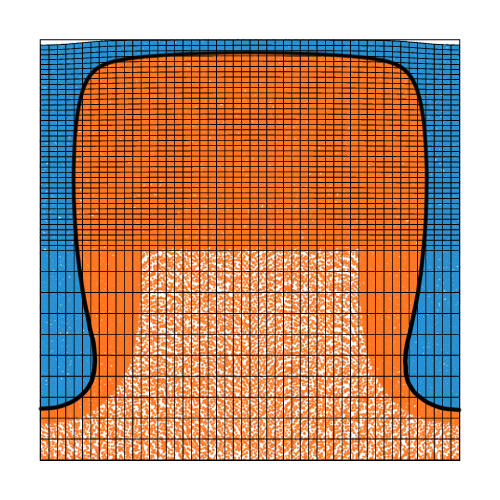

In [22]:
Fig.save("Fig_Kaus2010RTI_1.png")
Fig.show()


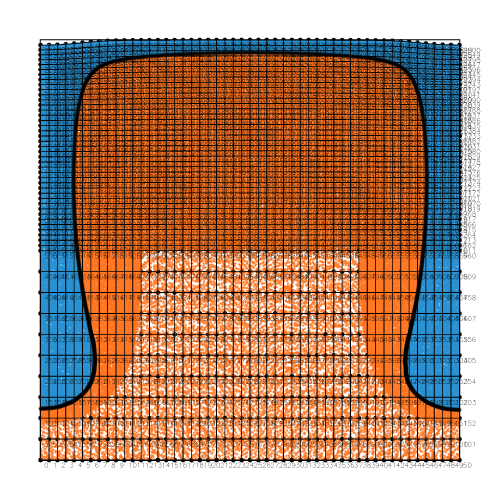

In [23]:
Fig1 = vis.Figure(figsize=(500, 500))
Fig1.Points(Model.interface_tracers, pointSize=5.0)
Fig1.Points(Model.swarm, Model.materialField,pointSize=3.,colourBar=False)
Fig1.Mesh(Model.mesh,nodeNumbers=True)
Fig1.save("Fig_Kaus2010RTI_tem.png")
Fig1.show()

In [24]:
idcell=Model.swarm.owningCell.data
np.where(idcell==0)[0].shape,np.where(idcell==2499)[0].shape,np.where(idcell==2399)[0].shape

((43,), (40,), (41,))

In [25]:
np.where(idcell==2199)[0].shape,np.where(idcell==1199)[0].shape

((45,), (42,))

In [27]:
Model.swarm.data.shape

(132552, 2)

In [28]:
for i in range(151,201):
    print(np.where(idcell==i)[0].shape)

(161,)
(166,)
(175,)
(184,)
(164,)
(169,)
(145,)
(129,)
(70,)
(42,)
(36,)
(44,)
(45,)
(43,)
(48,)
(41,)
(45,)
(44,)
(55,)
(37,)
(36,)
(40,)
(39,)
(41,)
(39,)
(40,)
(44,)
(39,)
(42,)
(43,)
(40,)
(42,)
(51,)
(47,)
(38,)
(37,)
(46,)
(40,)
(45,)
(78,)
(146,)
(149,)
(164,)
(182,)
(164,)
(164,)
(164,)
(165,)
(162,)
(157,)


In [29]:
for i in range(101,151):
    print(np.where(idcell==i)[0].shape)

(161,)
(164,)
(171,)
(156,)
(126,)
(101,)
(65,)
(46,)
(38,)
(45,)
(41,)
(42,)
(40,)
(41,)
(44,)
(42,)
(41,)
(45,)
(39,)
(39,)
(43,)
(44,)
(40,)
(39,)
(40,)
(42,)
(43,)
(47,)
(42,)
(43,)
(42,)
(45,)
(47,)
(37,)
(48,)
(49,)
(41,)
(43,)
(42,)
(43,)
(45,)
(65,)
(94,)
(123,)
(164,)
(164,)
(180,)
(170,)
(167,)
(161,)


In [30]:
!!999

['/bin/sh: 1: 999: not found']

In [ ]:
import h5py   
import matplotlib.pyplot as plt
import numpy as np
import math

def load_surf_swarm(fdir,step):
    fname = fdir+"interface-"+str(step)+".h5"
    fh5   = h5py.File(fname ,'r')  
    fdata = fh5["data"][()]
    xcoord = fdata[:,0]
    ycoord = fdata[:,1]
    return xcoord,ycoord

def load_depth(fdir,maxstep,dstep):
    depth_l = []
    depth_r = []
    for step in range(0,maxstep+1,dstep):
        xcoord,ycoord = load_surf_swarm(fdir,step)
        depth_l.append(ycoord[0])   
        depth_r.append(ycoord[-1])  
    return np.array(depth_l),np.array(depth_r)

In [ ]:
dt0,maxsteps0,dstep0,= 100,54,1
times0 = np.arange(0,dt0*maxsteps0+dt0*dstep0/2,dt0*dstep0)

fdir += "/"
depth0_l,depth0_r = load_depth(fdir,maxsteps0,dstep0)

In [ ]:
# # Fig 3 in Kaus et al., 2010

# fname = "Depth of the interface at x=−250km versus time for the free surface simulations"
# fig, ax1 = plt.subplots(nrows=1, figsize=(8,6))
# ax1.set(xlabel='Time [Myrs]', ylabel='Interface Depth [km]') 
# ax1.plot(times0/1000,depth0_l,'-k')
# ax1.set_ylim([-500,-100])
# ax1.set_xlim([0,6])
# ax1.grid()
# #ax1.legend(loc = 'lower right',prop = {'size':8})
# plt.savefig(fname,dpi=150,bbox_inches='tight')